# Human Activity Recognition(HAR)

- Reference article: https://towardsdatascience.com/human-activity-recognition-har-tutorial-with-keras-and-core-ml-part-1-8c05e365dfa0
- Reference code: https://github.com/ni79ls/har-keras-coreml/blob/master/Human%20Activity%20Recognition%20with%20Keras%20and%20CoreML.ipynb
- Dataset: https://www.cis.fordham.edu/wisdm/dataset.php

---

* Convert and reformat **accelerometer data** into a **time-sliced representation**
* **Visualize** the accelerometer data
* Reshape the **multi-dimensional tabular data** so that it is accepted by Keras


## Overview

- **accelererometer data** from a smartphone
    - x, y, z axis acceleration
    - timestamp
    - person ID
- **6 acitivites**
    - Walking
    - Jogging
    - Sitting
    - Standing
    - Upstairs
    - DownStairs
- **Model**: trained to classify between each of the 6 activities.
    1. DNN
    2. 1D CNN

In [291]:
import os
import warnings

import numpy

warnings.filterwarnings(action='ignore')

from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

# PyTorch Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader

# Check if CUDA/MPS is available (for GPU usage)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

print(device)

mps


Constants
- TIME_PERIODS: the length of the time segment
- STEP_DISTANCE: the amount of overlap between two consecutive time segments

In [292]:
# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')

# Class labels
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']

TIME_PERIODS = 80  # The number of steps within one time segment

# The steps to take from one segment to the next; if this value is equal to TIME_PERIODS,
# then there is no overlap between the segments
STEP_DISTANCE = 40


# Data

I used `/kaggle/input/activitydetectionimusensor/WISDM_ar_v1.1.1_raw.txt` data.
> (another dataset (later): `/kaggle/input/human-activity-recognition/time_series_data_human_activities.csv`)

In [293]:
# Define some functions to read the data and show some basic info about the data

def read_data(file_path):
    column_names = ['user', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']
    df = pd.read_csv(file_path, header=None, names=column_names)
    
    # Last column has a ";" character which must be removed
    df['z-axis'].replace(regex=True,
                         inplace=True,
                         to_replace=r';',
                         value=r'')
    
    
    df['z-axis'] = pd.to_numeric(df['z-axis'], errors='coerce')
    df.dropna(axis=0, how='any', inplace=True)  # Drop NaN values

    # Transform 'z-axis' column to float
    # df['z-axis'] = df['z-axis'].apply(convert_to_float)

    return df

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

def show_basic_dataframe_info(dataframe):
    # Shape: #_rows, #_columns
    print("Number of rows in the dataframe: %i" % (dataframe.shape[0]))
    print("Number of columns in the dataframe: %i" % (dataframe.shape[1]))


The data can be downloaded from **[here](https://www.kaggle.com/datasets/sosoyeong/wisdm-raw)**.

1.   List item
2.   List item

Then 'file_path' the directory to where you have put the data.

In [294]:
# from google.colab import drive
# drive.mount('/content/drive')

file_path = '../data/WISDM_ar_v1.1_raw.txt'
df = read_data(file_path)

In [295]:
show_basic_dataframe_info(df)
df.head(10)

Number of rows in the dataframe: 1098208
Number of columns in the dataframe: 6


user activity       timestamp  x-axis  y-axis  z-axis
0    33  Jogging  49105962326000    -0.7    12.7     0.5
1    33  Jogging  49106062271000     5.0    11.3     1.0
2    33  Jogging  49106112167000     4.9    10.9    -0.1
3    33  Jogging  49106222305000    -0.6    18.5     3.0
4    33  Jogging  49106332290000    -1.2    12.1     7.2
5    33  Jogging  49106442306000     1.4    -2.5    -6.5
6    33  Jogging  49106542312000    -0.6    10.6     5.7
7    33  Jogging  49106652389000    -0.5    13.9     7.1
8    33  Jogging  49106762313000    -8.4    11.4     5.1
9    33  Jogging  49106872299000     1.0     1.4     1.6

In [296]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1098208 entries, 0 to 1098208
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1098208 non-null  int64  
 1   activity   1098208 non-null  object 
 2   timestamp  1098208 non-null  int64  
 3   x-axis     1098208 non-null  float64
 4   y-axis     1098208 non-null  float64
 5   z-axis     1098208 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


In [297]:
# 80 steps => 4 sec (0.05 * 80 = 4)

def create_segments_and_labels(df, time_steps, step, label_name):
    # x, y, z acceleration as features
    N_FEATURES = 3

    # Number of steps to advance in each iteration
    # step = time_steps # no overlap between segments

    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]

        # find the most often used label in this segment
        label_mode_result = stats.mode(df[label_name][i: i + time_steps])
        if np.isscalar(label_mode_result.mode):
            label = label_mode_result.mode
        else:
            label = label_mode_result.mode[0]

        segments.append([xs, ys, zs])
        labels.append(label)

    # bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels  # x, y


x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)  # LABEL = 'ActivityEncoded'

x_validate, y_validate = create_segments_and_labels(df_validate,
                                                    TIME_PERIODS,
                                                    STEP_DISTANCE,
                                                    LABEL)  # LABEL = 'ActivityEncoded'

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

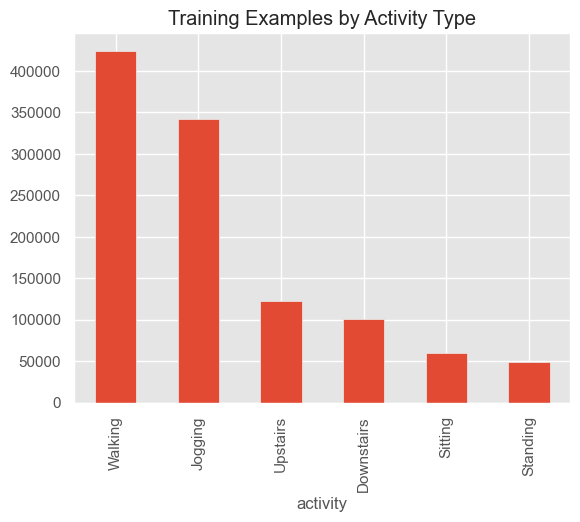

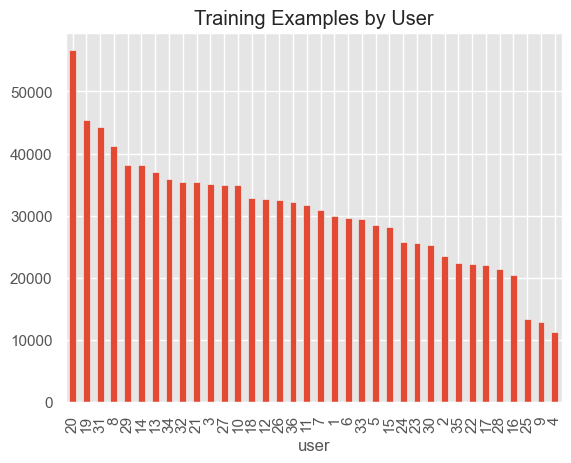

In [298]:
# by activity type
df['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()

# by user
df['user'].value_counts().plot(kind='bar',
                                  title='Training Examples by User')
plt.show()

- We have more data for walking and jogging activities more than other activities.
- 36 participants

<br>

**Accelerometer data** for six activities
- sampling rates 20Hz (20 values per second)
    - first 180 records == 9 second interval
        - 1/200 * 180 = 9 seconds

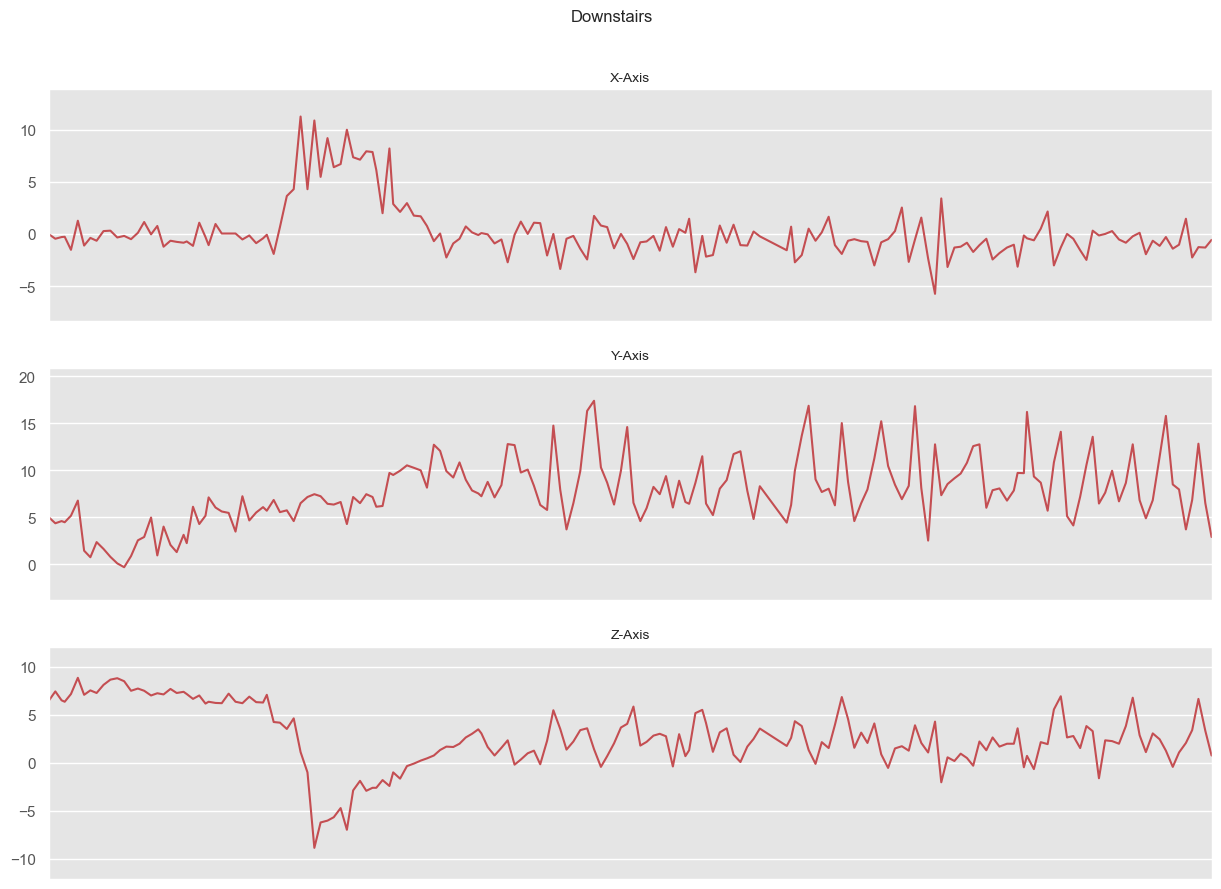

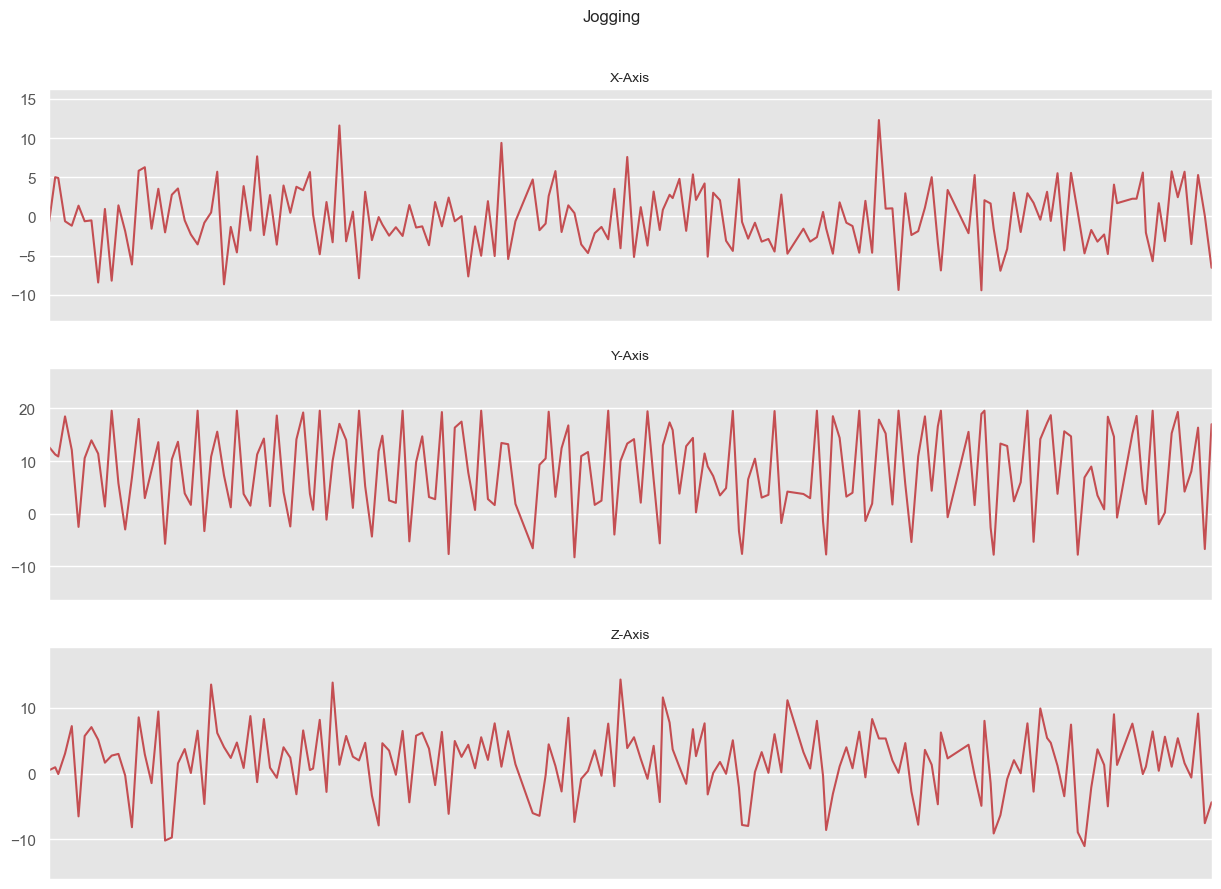

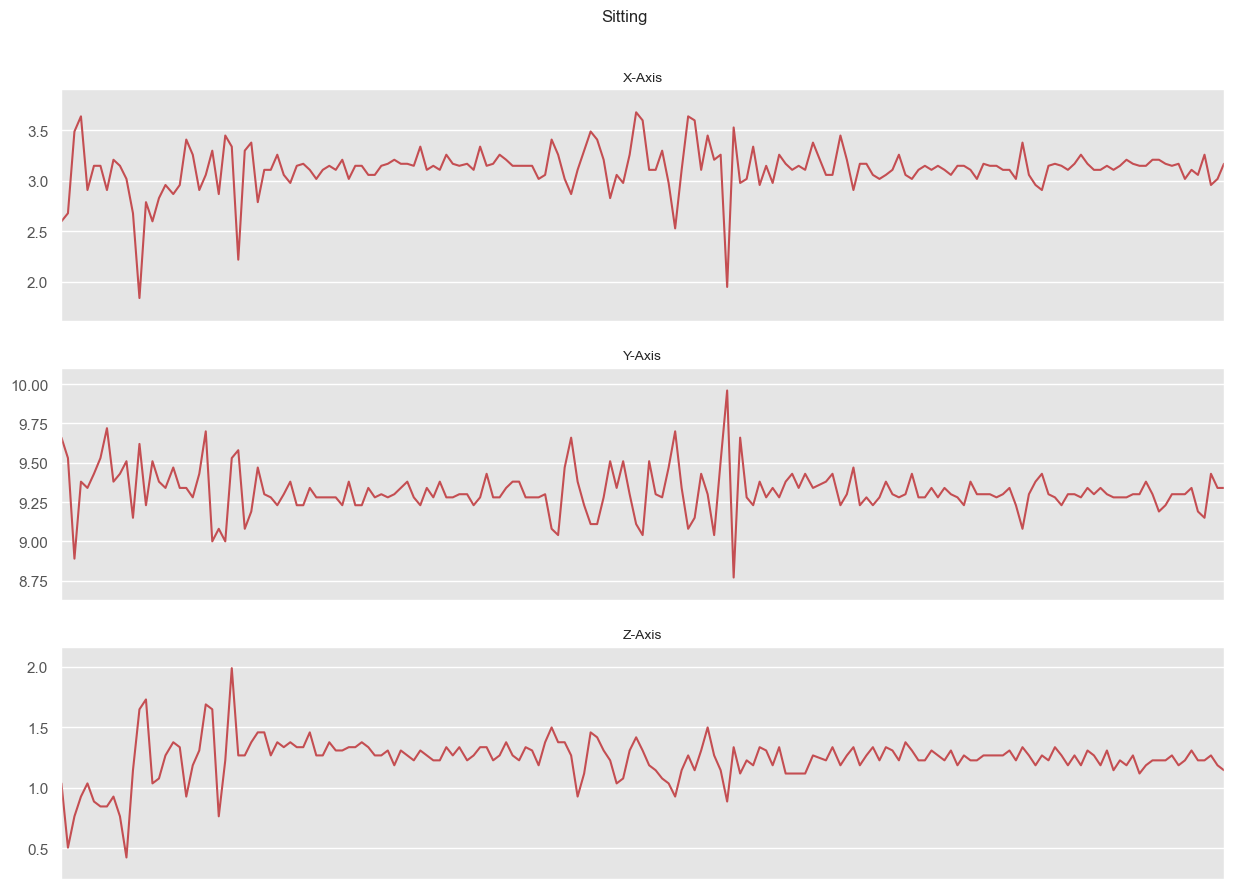

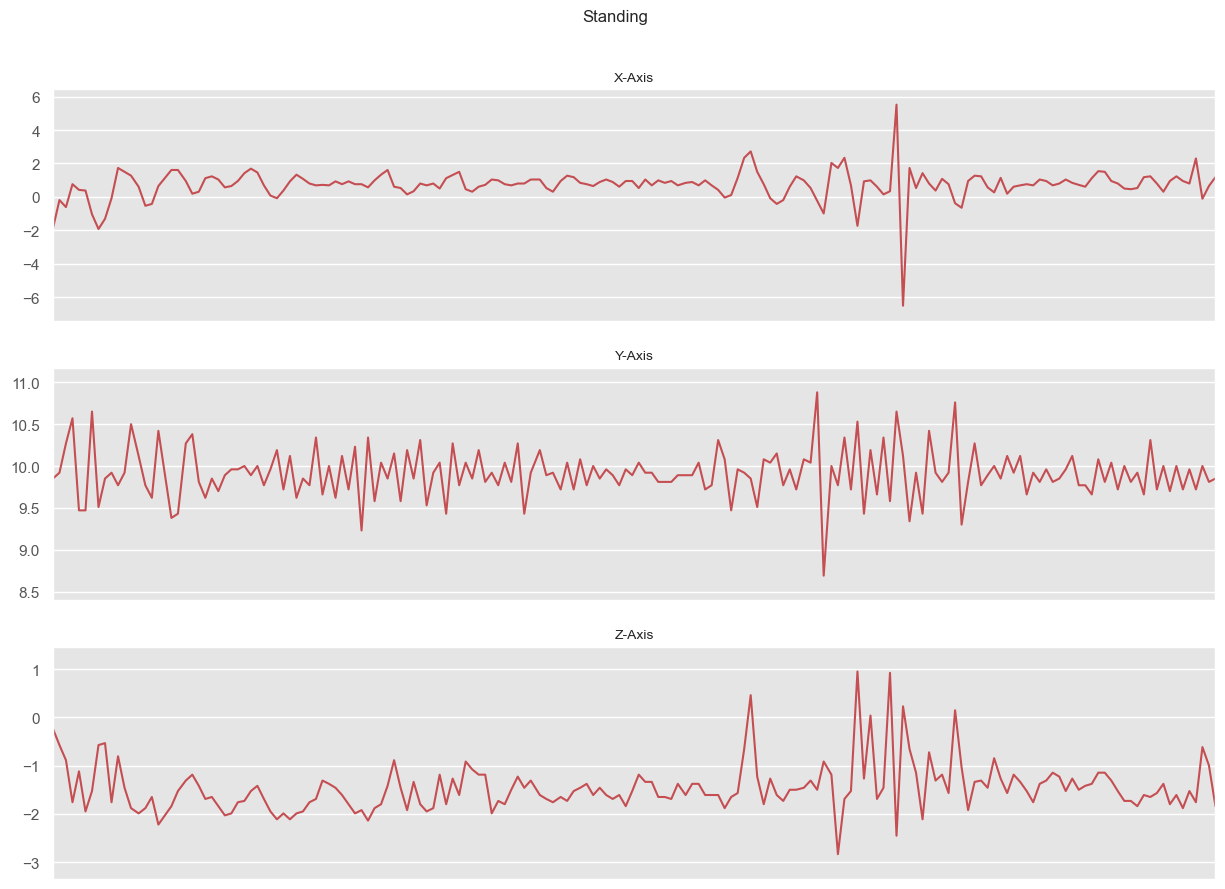

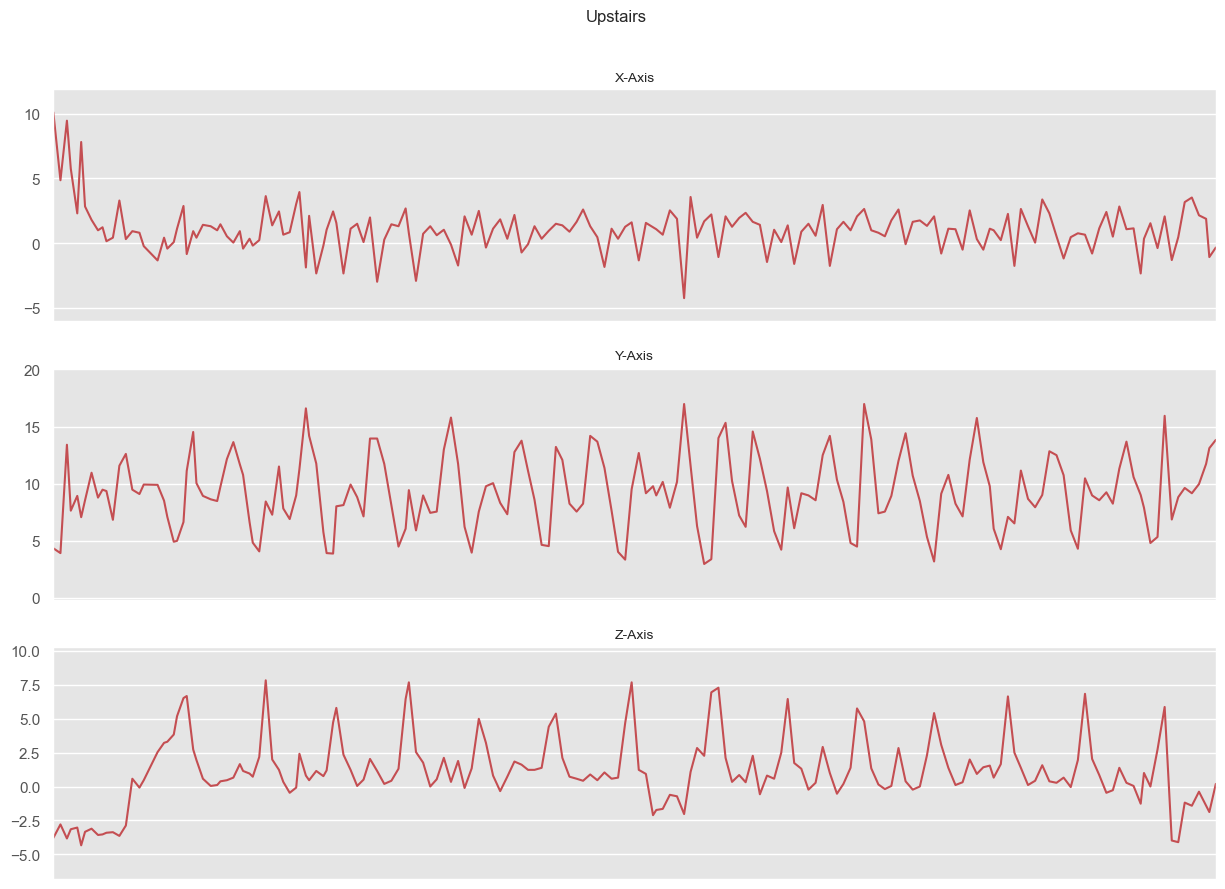

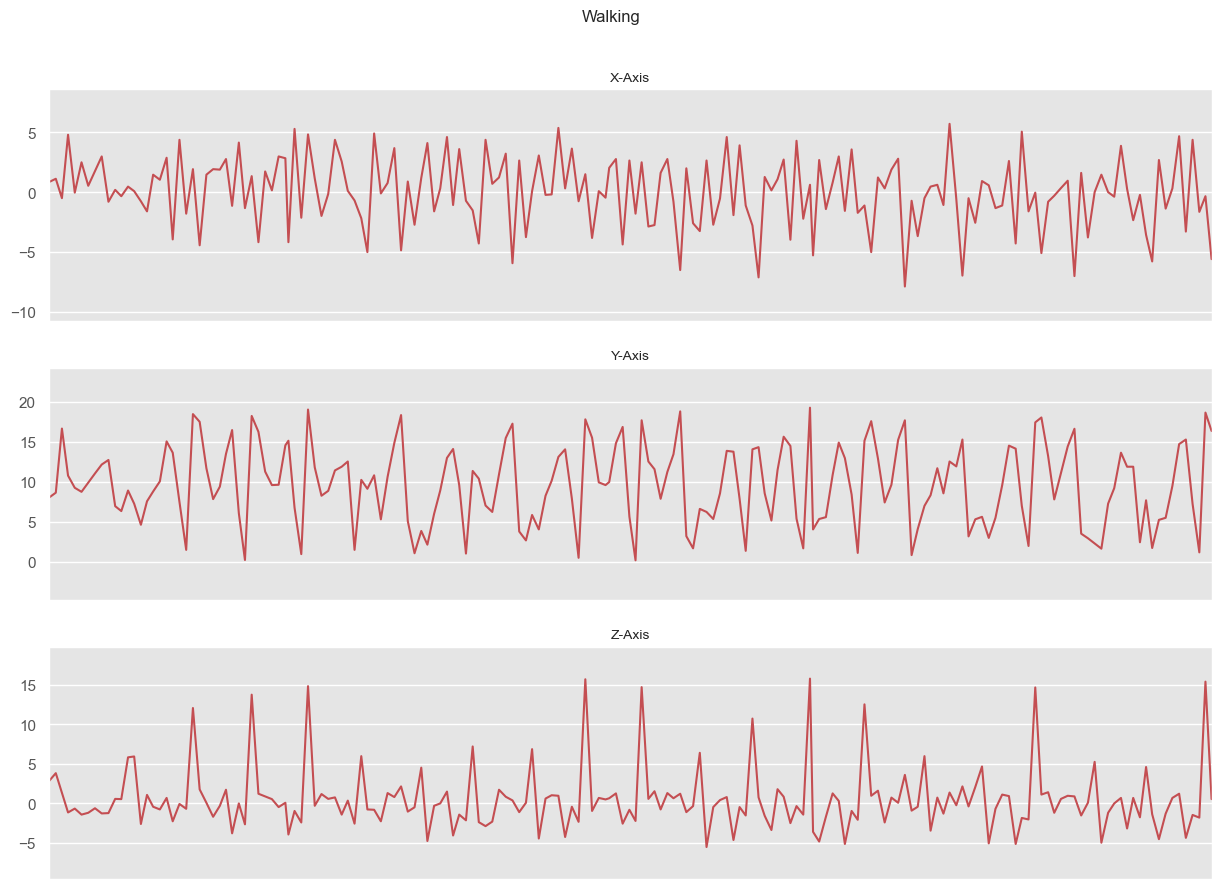

In [299]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 10), sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')  # x
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')  # y
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')  # z
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()


def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'r')
    ax.set_title(title, fontsize=10)
    ax.xaxis.set_visible(False)

    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:180]  # check only for first 180 records (9 seconds)
    plot_activity(activity, subset)

Activies like Walking and Jogging has higher acceleration compared to Sitting.

Add **new column** called **'ActivityEncoded'** to the dataframe
- encoded value for each activity
- Why?
    - DNN only work with numerical labels
        - **need to change string label to number!**
            0. Downstairs
            1. Jogging
            2. Sitting
            3. Standing
            4. Upstairs
            5. Walking

In [190]:
LABEL = 'ActivityEncoded'

le = preprocessing.LabelEncoder()  # string to Integer
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

df.head()

user activity       timestamp  x-axis  y-axis  z-axis  ActivityEncoded
0    33  Jogging  49105962326000    -0.7    12.7     0.5                1
1    33  Jogging  49106062271000     5.0    11.3     1.0                1
2    33  Jogging  49106112167000     4.9    10.9    -0.1                1
3    33  Jogging  49106222305000    -0.6    18.5     3.0                1
4    33  Jogging  49106332290000    -1.2    12.1     7.2                1

In [191]:
# Split data into train and test set
# train/validation: user 1 ~ 28
# test: user 28 ~

from sklearn.model_selection import train_test_split

df_train = df[df['user'] <= 28]
df_validate = df[df['user'].isin([31,30,29])]   # selects a portion of the data from df_train for validation purposes 
df_test = df[df['user'] >= 32]

print(df_train.shape)
print(df_validate.shape)
print(df_test.shape)

(834784, 7)
(107862, 7)
(155562, 7)


In [192]:
# normalize train data (value range: 0 ~ 1)
# normalization should be applied to test data in the same way
pd.options.mode.chained_assignment = None  # defual='warm'

df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()

df_validate['x-axis'] = df_validate['x-axis'] / df_validate['x-axis'].max()
df_validate['y-axis'] = df_validate['y-axis'] / df_validate['y-axis'].max()
df_validate['z-axis'] = df_validate['z-axis'] / df_validate['z-axis'].max()

df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()

# round numbers
df_train = df_train.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})
df_validate = df_validate.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})
df_test = df_test.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})

df_train.head()

user activity       timestamp  x-axis  y-axis  z-axis  ActivityEncoded
8489    17  Walking  57869902574000     0.0     0.5    -0.0                5
8490    17  Walking  57870012316000    -0.0     0.5    -0.0                5
8491    17  Walking  57870122301000    -0.0     0.5    -0.0                5
8492    17  Walking  57870222246000     0.0     0.5    -0.0                5
8493    17  Walking  57870332292000     0.0     0.5    -0.0                5

Still the dataframe is not ready yet to be fed into a neural network.

So, we need to reshpae it.

In [194]:
print(TIME_PERIODS, STEP_DISTANCE)

80 40


In [195]:
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

print('x_validate shape: ', x_validate.shape)
print(x_validate.shape[0], 'validation samples')
print('y_validate shape: ', y_validate.shape)

print('x_test shape: ', x_test.shape)
print(x_test.shape[0], 'test samples')
print('y_test shape: ', y_test.shape)

x_train shape:  (20868, 80, 3)
20868 training samples
y_train shape:  (20868,)
x_validate shape:  (2695, 80, 3)
2695 validation samples
y_validate shape:  (2695,)
x_test shape:  (3888, 80, 3)
3888 test samples
y_test shape:  (3888,)


`x_train` has 20868 records of 2D-matrix of shape 80x3.

**Dimensions we need to remeber**

- #_time periods: the number of time periods within 1 record
    - 4 second interval => 80
- #_sensors: 3 (x, y, z axis acceleration)
- #_classes: the number of the nodes for output layer -> 6

In [196]:
# input, output dimensions
n_time_periods, n_sensors = x_train.shape[1], x_train.shape[2]
n_classes = le.classes_.size
print(list(le.classes_))
print(n_time_periods, n_sensors)

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
80 3


The input data is 2D (80x3).


In [197]:
input_shape = (n_time_periods * n_sensors)

x_train = x_train.reshape(x_train.shape[0], input_shape)
x_validate = x_validate.reshape(x_validate.shape[0], input_shape)
x_test =  x_test.reshape(x_test.shape[0], input_shape)

print('x_train shape:', x_train.shape)
print('x_validate shape:', x_validate.shape)
print('x_test shape:', x_test.shape)
print('input shape:', input_shape)

x_train shape: (20868, 240)
x_validate shape: (2695, 240)
x_test shape: (3888, 240)
input shape: 240


In [199]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

x_validate = x_validate.astype('float32')
y_validate = y_validate.astype('float32')

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

In [200]:
def to_categorical(y, num_classes):
    return torch.eye(num_classes)[y]

n_classes = len(np.unique(y_train))  # Assuming y_train is available and contains your class labels
y_train_hot = to_categorical(y_train, n_classes)

print('New y_train shape: ', y_train_hot.shape)

New y_train shape:  torch.Size([20868, 6])


In PyTorch, we need to wrap these NumPy arrays into a dataset and then create a DataLoader for batch processing.

In [201]:
# Convert your numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # long for CrossEntropyLoss
x_validate_tensor = torch.tensor(x_validate, dtype=torch.float32)
y_validate_tensor = torch.tensor(y_validate, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
validate_dataset = TensorDataset(x_validate_tensor, y_validate_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 64  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Multi-layer Perceptron

## Base MLP

In [38]:
# Create DataLoaders
batch_size = 64  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Multi-layer Perceptron
class MLP(nn.Module):
    def __init__(self, time_periods, n_classes):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(time_periods * 3, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, n_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)
    
    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions


# Assuming TIME_PERIODS and n_classes are defined
model_mlp_base = MLP(TIME_PERIODS, n_classes)

model_mlp.to(device)

# Print model summary
print(model_mlp)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_mlp.parameters(), lr=0.001)

BATCH_SIZE = 64
EPOCHS = 200

train_losses_base = []
val_losses = []
train_accs = []
val_accs = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses.append(test_loss)
    val_accs.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(validate_loader.dataset)} ({accuracy:.2f}%)')

for epoch in range(1, EPOCHS + 1):
    train(model_mlp, device, train_loader, my_optimizer, epoch)
    validate(model_mlp, device, validate_loader)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=240, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.012901 	Accuracy: 71.54%
Validation: Average loss: 0.0151, Accuracy: 1752/2695 (65.01%)
Train Epoch: 2 	Loss: 0.007500 	Accuracy: 82.48%
Validation: Average loss: 0.0180, Accuracy: 1765/2695 (65.49%)
Train Epoch: 3 	Loss: 0.005530 	Accuracy: 86.14%
Validation: Average loss: 0.0188, Accuracy: 1872/2695 (69.46%)
Train Epoch: 4 	Loss: 0.004666 	Accuracy: 88.65%
Validation: Average loss: 0.0219, Accuracy: 1905/2695 (70.69%)
Train Epoch: 5 	Loss: 0.004002 	Accuracy: 89.97%
Validation: Average loss: 0.0147, Accuracy: 2021/2695 (74.99%)
Train Epoch: 6 	Loss: 0.003522 	Accuracy: 91.19%
Validation: Average loss: 0.0148, Accuracy: 2075/2695 (76.99%)
Train Epoch: 7 	Loss: 0.00316

Accuracy on val data:  80.03710575139146
Loss on val data:  0.02725786114575218


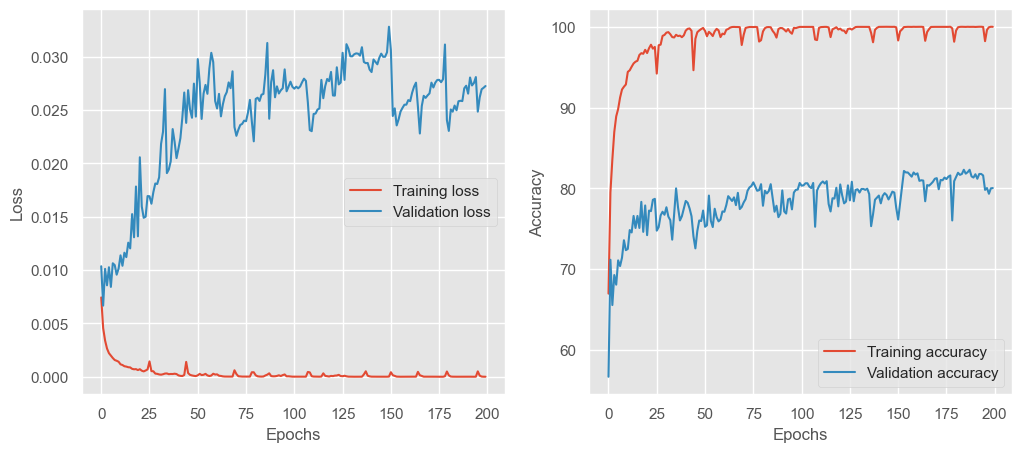

In [35]:
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy')
    plt.plot(val_accs, label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
print('Accuracy on val data: ', val_accs[-1])
print('Loss on val data: ', val_losses[-1])

plot_performance(train_losses, val_losses, train_accs, val_accs)

Result from the article

![Expectation](attachment:16797bb4-c2ae-4f1b-8a7a-e195e39da9c3.png)

## Configuration 1: Increase the Number of Hidden Layers and Use Sigmoid Activation

In [43]:
# Create DataLoaders
batch_size = 64  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Multi-layer Perceptron
class MLP_Config1(nn.Module):
    def __init__(self, time_periods, n_classes):
        super(MLP_Config1, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(time_periods * 3, 150)
        self.fc2 = nn.Linear(150, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 100)
        self.fc5 = nn.Linear(100, 100)
        self.fc6 = nn.Linear(100, n_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))
        x = self.fc6(x)
        return F.log_softmax(x, dim=1)
    
    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions


# Assuming TIME_PERIODS and n_classes are defined
model_mlp = MLP_Config1(TIME_PERIODS, n_classes)

model_mlp.to(device)

# Print model summary
print(model_mlp)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_mlp.parameters(), lr=0.001)

BATCH_SIZE = 64
EPOCHS = 200

train_losses = []
val_losses = []
train_accs = []
val_accs = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses.append(test_loss)
    val_accs.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(validate_loader.dataset)} ({accuracy:.2f}%)')

for epoch in range(1, EPOCHS + 1):
    train(model_mlp, device, train_loader, my_optimizer, epoch)
    validate(model_mlp, device, validate_loader)

MLP_Config1(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=240, out_features=150, bias=True)
  (fc2): Linear(in_features=150, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=100, bias=True)
  (fc5): Linear(in_features=100, out_features=100, bias=True)
  (fc6): Linear(in_features=100, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.021402 	Accuracy: 48.75%
Validation: Average loss: 0.0261, Accuracy: 1142/2695 (42.37%)
Train Epoch: 2 	Loss: 0.016661 	Accuracy: 65.07%
Validation: Average loss: 0.0226, Accuracy: 1489/2695 (55.25%)
Train Epoch: 3 	Loss: 0.013714 	Accuracy: 72.45%
Validation: Average loss: 0.0240, Accuracy: 1516/2695 (56.25%)
Train Epoch: 4 	Loss: 0.012528 	Accuracy: 74.02%
Validation: Average loss: 0.0238, Accuracy: 1517/2695 (56.29%)
Train Epoch: 5 	Loss: 0.011896 	Accuracy: 75.28%
Validation: Average loss: 0.0235, Accuracy: 1552/2695 (57.59%)
Train Epo

Accuracy on val data:  67.82931354359926
Loss on val data:  0.035395404011298814


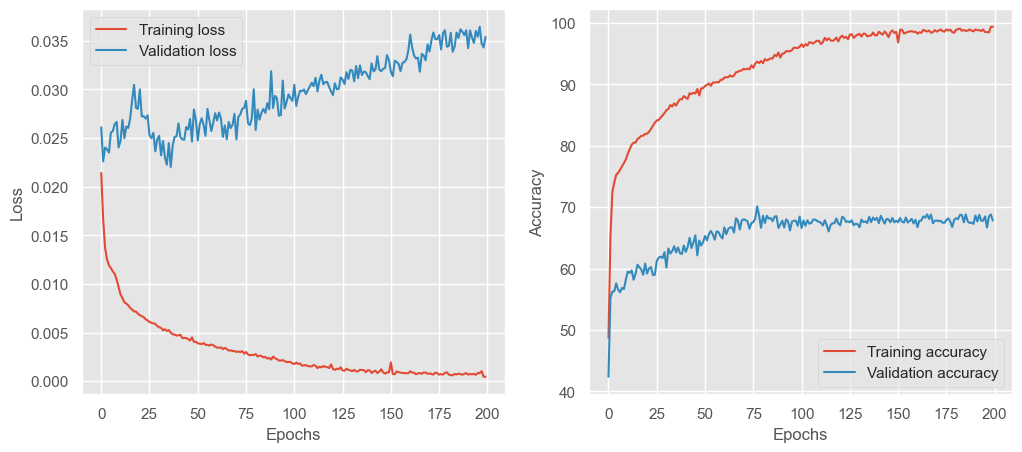

In [44]:
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy')
    plt.plot(val_accs, label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
print('Accuracy on val data: ', val_accs[-1])
print('Loss on val data: ', val_losses[-1])

plot_performance(train_losses, val_losses, train_accs, val_accs)

## Configuration 2: Reduce the Number of Hidden Layers, Use Tanh Activation and Increase Units in Hidden Layers

In [60]:
# Create DataLoaders
batch_size = 128  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Multi-layer Perceptron
class MLP_Config2(nn.Module):
    def __init__(self, time_periods, n_classes):
        super(MLP_Config2, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(time_periods * 3, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, n_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
    
    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions


# Assuming TIME_PERIODS and n_classes are defined
model_mlp = MLP_Config2(TIME_PERIODS, n_classes)

model_mlp.to(device)

# Print model summary
print(model_mlp)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_mlp.parameters(), lr=0.001)

BATCH_SIZE = 128
EPOCHS = 100

train_losses = []
val_losses = []
train_accs = []
val_accs = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses.append(test_loss)
    val_accs.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(validate_loader.dataset)} ({accuracy:.2f}%)')

for epoch in range(1, EPOCHS + 1):
    train(model_mlp, device, train_loader, my_optimizer, epoch)
    validate(model_mlp, device, validate_loader)

MLP_Config2(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=240, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.009613 	Accuracy: 56.00%
Validation: Average loss: 0.0155, Accuracy: 1495/2695 (55.47%)
Train Epoch: 2 	Loss: 0.007289 	Accuracy: 70.62%
Validation: Average loss: 0.0133, Accuracy: 1523/2695 (56.51%)
Train Epoch: 3 	Loss: 0.006091 	Accuracy: 74.72%
Validation: Average loss: 0.0147, Accuracy: 1534/2695 (56.92%)
Train Epoch: 4 	Loss: 0.005727 	Accuracy: 75.92%
Validation: Average loss: 0.0146, Accuracy: 1557/2695 (57.77%)
Train Epoch: 5 	Loss: 0.005383 	Accuracy: 76.80%
Validation: Average loss: 0.0133, Accuracy: 1570/2695 (58.26%)
Train Epoch: 6 	Loss: 0.005172 	Accuracy: 77.46%
Validation: Average loss: 0.0131, Accuracy: 1572/2695 (58.33%)
Train Epoch: 7 	Loss: 0.004953 	Accuracy: 78.18%
Validation: Average loss: 0.0128, 

Accuracy on val data:  77.5139146567718
Loss on val data:  0.0166674168992468


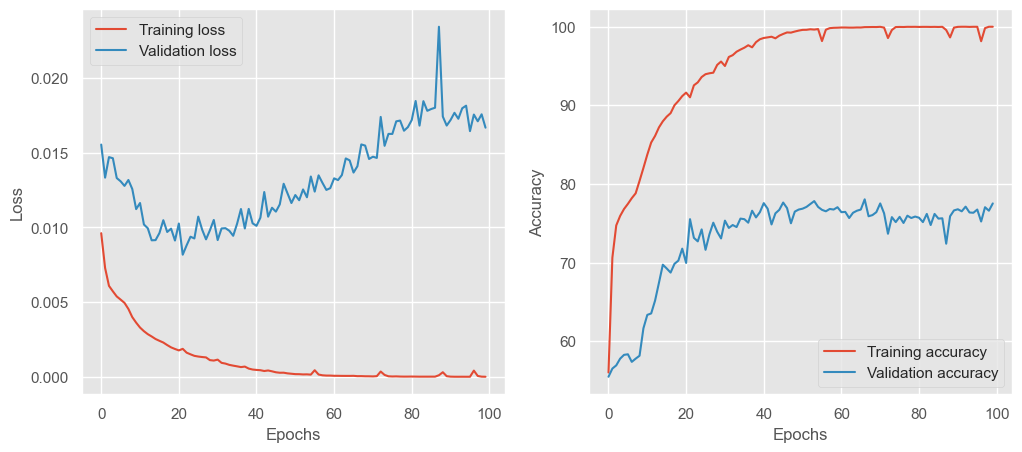

In [63]:
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy')
    plt.plot(val_accs, label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
print('Accuracy on val data: ', val_accs[-1])
print('Loss on val data: ', val_losses[-1])

plot_performance(train_losses, val_losses, train_accs, val_accs)

## Configuration 3: Use ReLU Activation، Increase Units in Hidden Layers, Batch Size and Decrease 

In [94]:
# Create DataLoaders
batch_size = 256  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Multi-layer Perceptron
class MLP_Config3(nn.Module):
    def __init__(self, time_periods, n_classes):
        super(MLP_Config3, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(time_periods * 3, 150)
        self.fc2 = nn.Linear(150, 150)
        self.fc3 = nn.Linear(150, 100)
        self.fc4 = nn.Linear(100, n_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)
    
    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions


# Assuming TIME_PERIODS and n_classes are defined
model_mlp = MLP_Config3(TIME_PERIODS, n_classes)

model_mlp.to(device)

# Print model summary
print(model_mlp)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_mlp.parameters(), lr=0.003)

BATCH_SIZE = 400
EPOCHS = 100

train_losses = []
val_losses = []
train_accs = []
val_accs = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses.append(test_loss)
    val_accs.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(validate_loader.dataset)} ({accuracy:.2f}%)')

for epoch in range(1, EPOCHS + 1):
    train(model_mlp, device, train_loader, my_optimizer, epoch)
    validate(model_mlp, device, validate_loader)

MLP_Config3(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=240, out_features=150, bias=True)
  (fc2): Linear(in_features=150, out_features=150, bias=True)
  (fc3): Linear(in_features=150, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.003578 	Accuracy: 67.90%
Validation: Average loss: 0.0048, Accuracy: 1560/2695 (57.88%)
Train Epoch: 2 	Loss: 0.001954 	Accuracy: 81.69%
Validation: Average loss: 0.0037, Accuracy: 1849/2695 (68.61%)
Train Epoch: 3 	Loss: 0.001310 	Accuracy: 87.04%
Validation: Average loss: 0.0026, Accuracy: 2088/2695 (77.48%)
Train Epoch: 4 	Loss: 0.001064 	Accuracy: 89.48%
Validation: Average loss: 0.0038, Accuracy: 1983/2695 (73.58%)
Train Epoch: 5 	Loss: 0.000932 	Accuracy: 90.56%
Validation: Average loss: 0.0047, Accuracy: 1913/2695 (70.98%)
Train Epoch: 6 	Loss: 0.000810 	Accuracy: 91.73%
Validation: Average loss: 0.0040, Accuracy: 2118/2695 (78.59%)
Train Epoch: 7 	Loss:

Accuracy on val data:  83.00556586270872
Loss on val data:  0.013615030248291748


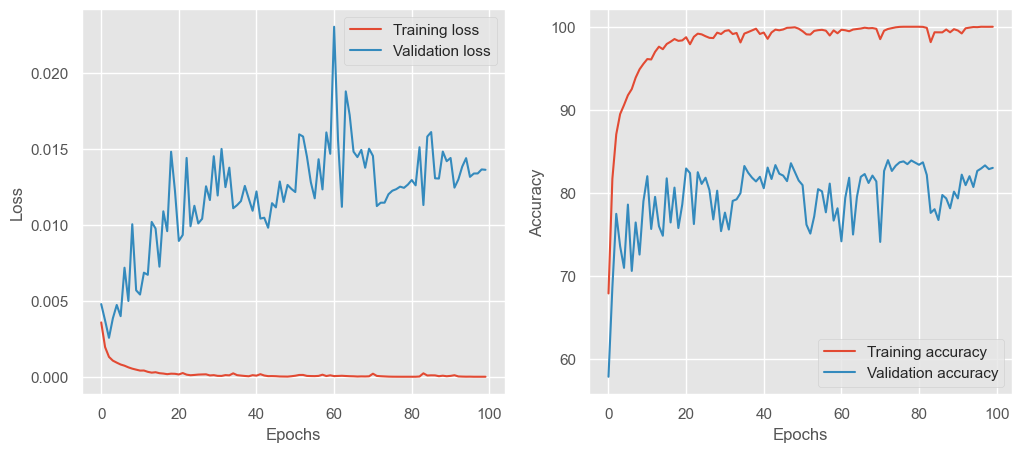

In [98]:
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy')
    plt.plot(val_accs, label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
print('Accuracy on val data: ', val_accs[-1])
print('Loss on val data: ', val_losses[-1])

plot_performance(train_losses, val_losses, train_accs, val_accs)

## Test

[[142   0   2  26 108  10]
 [ 47 775   0   0 153  34]
 [  0   0 223   0   0   0]
 [  2   0   0 112  35   0]
 [ 65   0   2   6 194  22]
 [123   9   0   0  62 848]]


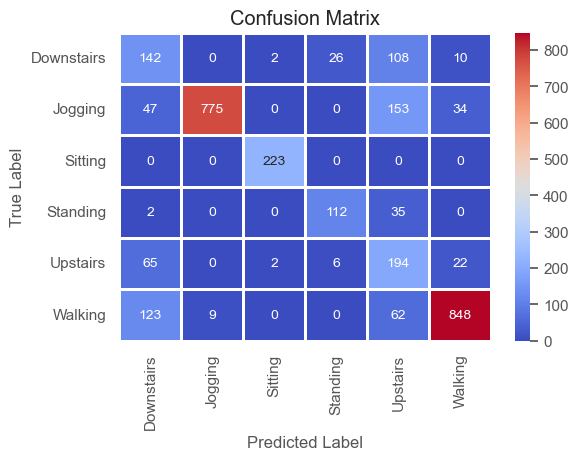

              precision    recall  f1-score   support

           0       0.37      0.49      0.43       288
           1       0.99      0.77      0.86      1009
           2       0.98      1.00      0.99       223
           3       0.78      0.75      0.76       149
           4       0.35      0.67      0.46       289
           5       0.93      0.81      0.87      1042

    accuracy                           0.76      3000
   macro avg       0.73      0.75      0.73      3000
weighted avg       0.84      0.76      0.79      3000


In [99]:
def show_confusion_matrix(validaitons, predictions, title=None):
    matrix = metrics.confusion_matrix(validaitons, predictions)
    print(matrix)
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    if title: plt.title(title)
    else: plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Get the predictions and true labels
all_predictions = []
all_labels = []
for data, labels in test_loader:
    data = data.to(device)
    predictions = model_mlp.predict(data)
    all_predictions.extend(predictions.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

show_confusion_matrix(all_labels, all_predictions)
print(classification_report(all_labels, all_predictions))

---

# 1D CNN

* Reference article: https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf
* Reference code: https://github.com/ni79ls/har-keras-cnn/blob/master/20180903_Keras_HAR_WISDM_CNN_v1.0_for_medium.py

 A 1D CNN is very effective when you expect to derive interesting features from shorter (fixed-length) segments of the overall data set and where the location of the feature within the segment is not of high relevance.


This applies well to the analysis of time sequences of sensor data (such as gyroscope or accelerometer data). It also applies to the analysis of any kind of signal data over a fixed-length period (such as audio signals).


## Base CNN

In [116]:
# Create DataLoaders
batch_size = 400  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 1D Convolutional Neural Network
class CNN(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(CNN, self).__init__()
        self.n_sensors = n_sensors
        self.time_periods = time_periods
        self.conv1 = nn.Conv1d(n_sensors, 100, kernel_size=10)
        self.conv2 = nn.Conv1d(100, 100, kernel_size=10)
        self.conv3 = nn.Conv1d(100, 160, kernel_size=10)
        self.conv4 = nn.Conv1d(160, 160, kernel_size=10)
        self.maxpool = nn.MaxPool1d(3)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(160, n_classes)

    def forward(self, x):
        x = x.view(-1, self.n_sensors, self.time_periods)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.adaptive_pool(x)
        x = self.dropout(x)
        x = x.view(-1, 160)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn = CNN(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn.to(device)

# Print model summary
print(model_cnn)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

BATCH_SIZE = 400
EPOCHS = 50

train_losses = []
val_losses = []
train_accs = []
val_accs = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses.append(test_loss)
    val_accs.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

for epoch in range(1, EPOCHS + 1):
    train(model_cnn, device, train_loader, my_optimizer, epoch)
    validate(model_cnn, device, test_loader)

CNN(
  (conv1): Conv1d(3, 100, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(10,), stride=(1,))
  (conv3): Conv1d(100, 160, kernel_size=(10,), stride=(1,))
  (conv4): Conv1d(160, 160, kernel_size=(10,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=160, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.002284 	Accuracy: 67.56%
Validation: Average loss: 0.0020, Accuracy: 2206/3000 (73.53%)
Train Epoch: 2 	Loss: 0.001235 	Accuracy: 82.05%
Validation: Average loss: 0.0015, Accuracy: 2482/3000 (82.73%)
Train Epoch: 3 	Loss: 0.000842 	Accuracy: 87.79%
Validation: Average loss: 0.0014, Accuracy: 2521/3000 (84.03%)
Train Epoch: 4 	Loss: 0.000639 	Accuracy: 90.27%
Validation: Average loss: 0.0014, Accuracy: 2423/3000 (80.77%)
Train Epoch: 5 	Loss: 0.000571 	Accuracy: 91.88%
Validation: Aver

Accuracy on val data:  86.1
Loss on val data:  0.0017319660463059941


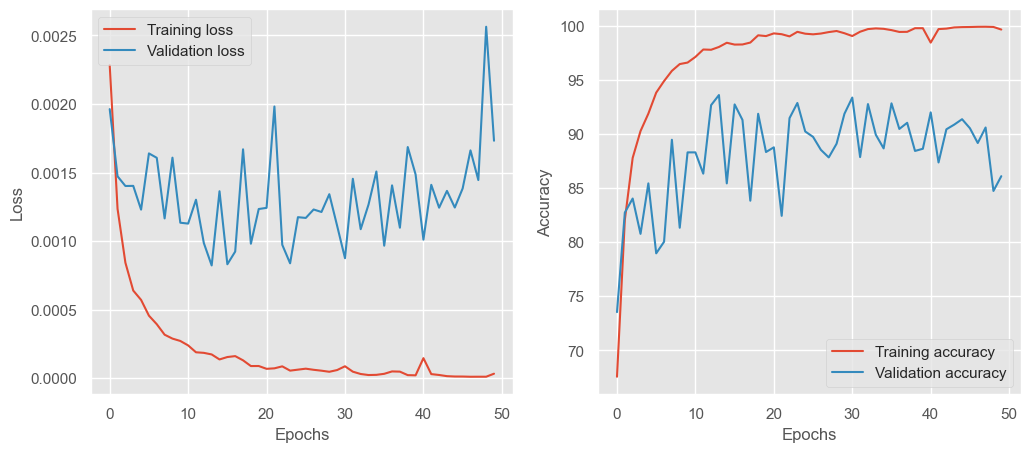

In [117]:
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy')
    plt.plot(val_accs, label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
print('Accuracy on val data: ', val_accs[-1])
print('Loss on val data: ', val_losses[-1])

plot_performance(train_losses, val_losses, train_accs, val_accs)

## CNN with early stopping

In [114]:
# Create DataLoaders
batch_size = 64  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 1D Convolutional Neural Network
class CNN(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(CNN, self).__init__()
        self.n_sensors = n_sensors
        self.time_periods = time_periods
        self.n_classes = n_classes
        self.conv1 = nn.Conv1d(n_sensors, 100, kernel_size=10)
        self.conv2 = nn.Conv1d(100, 100, kernel_size=10)
        self.conv3 = nn.Conv1d(100, 160, kernel_size=10)
        self.conv4 = nn.Conv1d(160, 160, kernel_size=10)
        self.maxpool = nn.MaxPool1d(3)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(160, n_classes)

    def forward(self, x):
        x = x.view(-1, self.n_sensors, self.time_periods)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.adaptive_pool(x)
        x = self.dropout(x)
        x = x.view(-1, 160)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn = CNN(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn.to(device)

# Print model summary
print(model_cnn)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

BATCH_SIZE = 64
EPOCHS = 500

train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_loss = float('inf')
patience = 100
trigger_times = 0

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    global best_val_loss, trigger_times
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses.append(test_loss)
    val_accs.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            return True
    return False

for epoch in range(1, EPOCHS + 1):
    train(model_cnn, device, train_loader, my_optimizer, epoch)
    if validate(model_cnn, device, test_loader):
        break

CNN(
  (conv1): Conv1d(3, 100, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(10,), stride=(1,))
  (conv3): Conv1d(100, 160, kernel_size=(10,), stride=(1,))
  (conv4): Conv1d(160, 160, kernel_size=(10,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=160, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.008223 	Accuracy: 80.51%
Validation: Average loss: 0.0076, Accuracy: 2497/3000 (83.23%)
Train Epoch: 2 	Loss: 0.003514 	Accuracy: 91.61%
Validation: Average loss: 0.0075, Accuracy: 2634/3000 (87.80%)
Train Epoch: 3 	Loss: 0.002280 	Accuracy: 95.28%
Validation: Average loss: 0.0126, Accuracy: 2356/3000 (78.53%)
Train Epoch: 4 	Loss: 0.001547 	Accuracy: 97.08%
Validation: Average loss: 0.0089, Accuracy: 2506/3000 (83.53%)
Train Epoch: 5 	Loss: 0.001210 	Accuracy: 97.78%
Validation: Aver

Accuracy on val data:  93.86666666666666
Loss on val data:  0.003577959400950904


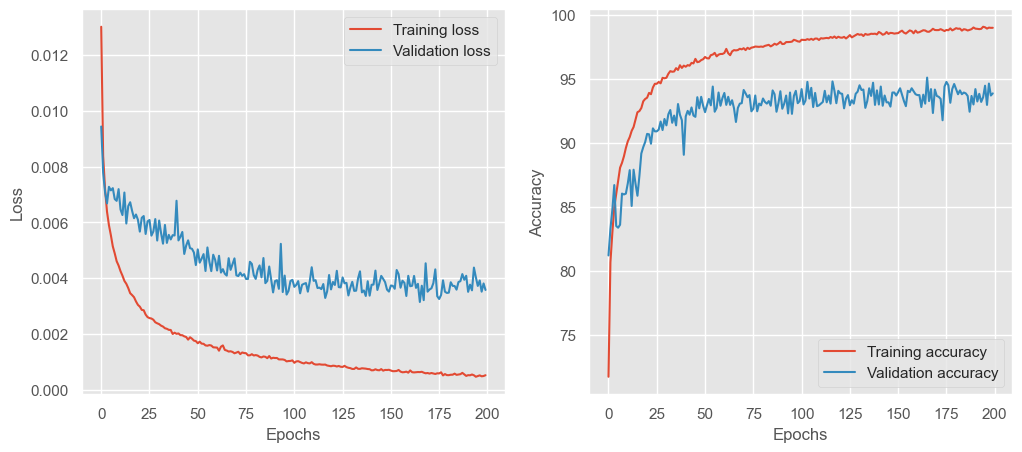

In [122]:
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy')
    plt.plot(val_accs, label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
print('Accuracy on val data: ', val_accs[-1])
print('Loss on val data: ', val_losses[-1])

plot_performance(train_losses, val_losses, train_accs, val_accs)

## Configuration 1: Reduced Number of Convolutional Layers

In [127]:
# Create DataLoaders
batch_size = 64  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class CNN_Config1(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(CNN_Config1, self).__init__()
        self.n_sensors = n_sensors
        self.time_periods = time_periods
        self.n_classes = n_classes
        self.conv1 = nn.Conv1d(n_sensors, 64, kernel_size=5)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5)
        self.maxpool = nn.MaxPool1d(2)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, n_classes)

    def forward(self, x):
        x = x.view(-1, self.n_sensors, self.time_periods)
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.adaptive_pool(x)
        x = self.dropout(x)
        x = x.view(-1, 128)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn_config1 = CNN_Config1(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn_config1.to(device)

# Print model summary
print(model_cnn_config1)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_cnn_config1.parameters(), lr=0.001)

BATCH_SIZE = 64
EPOCHS = 500

train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_loss = float('inf')
patience = 100
trigger_times = 0

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    global best_val_loss, trigger_times
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses.append(test_loss)
    val_accs.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            return True
    return False

for epoch in range(1, EPOCHS + 1):
    train(model_cnn_config1, device, train_loader, my_optimizer, epoch)
    if validate(model_cnn_config1, device, test_loader):
        break

CNN_Config1(
  (conv1): Conv1d(3, 64, kernel_size=(5,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.012656 	Accuracy: 72.33%
Validation: Average loss: 0.0091, Accuracy: 2462/3000 (82.07%)
Train Epoch: 2 	Loss: 0.008056 	Accuracy: 81.15%
Validation: Average loss: 0.0075, Accuracy: 2533/3000 (84.43%)
Train Epoch: 3 	Loss: 0.006740 	Accuracy: 84.11%
Validation: Average loss: 0.0069, Accuracy: 2583/3000 (86.10%)
Train Epoch: 4 	Loss: 0.006031 	Accuracy: 85.66%
Validation: Average loss: 0.0069, Accuracy: 2565/3000 (85.50%)
Train Epoch: 5 	Loss: 0.005439 	Accuracy: 87.02%
Validation: Average loss: 0.0069, Accuracy: 2571/3000 (85.70%)
Train Epoch: 6 	Loss: 0.005085 	Accuracy: 88.16%
Validation: Average 

Accuracy on val data:  90.26666666666667
Loss on val data:  0.008463472017480093


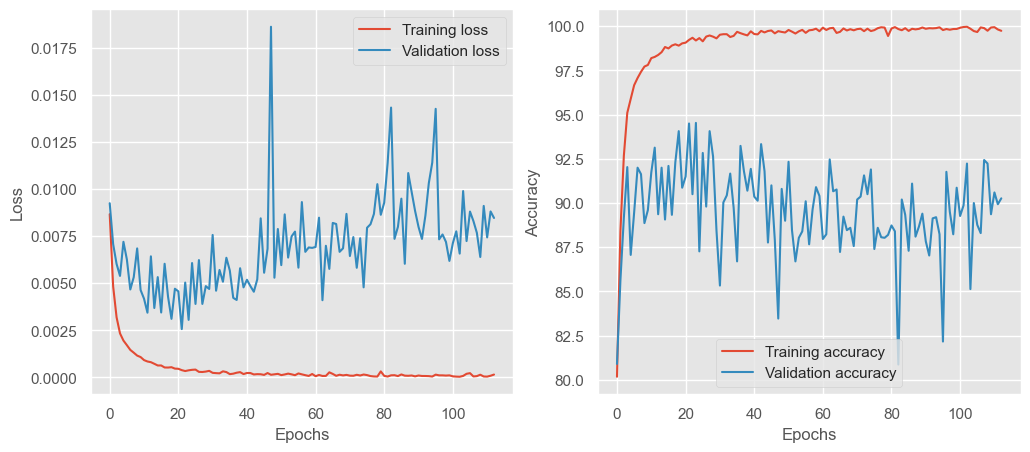

In [141]:
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy')
    plt.plot(val_accs, label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
print('Accuracy on val data: ', val_accs[-1])
print('Loss on val data: ', val_losses[-1])

plot_performance(train_losses, val_losses, train_accs, val_accs)

## Configuration 2: Used 3 Convolutional Layers and just Average Pooling and Leaky Relu Activation Functions

In [139]:
# Create DataLoaders
batch_size = 64  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class CNN_Config2(nn.Module):    
    def __init__(self, time_periods, n_sensors, n_classes):
        super(CNN_Config2, self).__init__()
        self.n_sensors = n_sensors
        self.time_periods = time_periods
        self.n_classes = n_classes
        self.conv1 = nn.Conv1d(n_sensors, 100, kernel_size=10)
        self.conv2 = nn.Conv1d(100, 100, kernel_size=10)
        self.conv3 = nn.Conv1d(100, 160, kernel_size=10)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(160, n_classes)

    def forward(self, x):
        x = x.view(-1, self.n_sensors, self.time_periods)
        x = F.leaky_relu(self.conv1(x), negative_slope=0.01)
        x = F.leaky_relu(self.conv2(x), negative_slope=0.01)
        x = F.leaky_relu(self.conv3(x), negative_slope=0.01)
        x = self.adaptive_pool(x)
        x = self.dropout(x)
        x = x.view(-1, 160)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn_config2 = CNN_Config2(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn_config2.to(device)

# Print model summary
print(model_cnn_config2)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_cnn_config2.parameters(), lr=0.001)

BATCH_SIZE = 400
EPOCHS = 500

train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_loss = float('inf')
patience = 100
trigger_times = 0

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    global best_val_loss, trigger_times
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses.append(test_loss)
    val_accs.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            return True
    return False

for epoch in range(1, EPOCHS + 1):
    train(model_cnn_config2, device, train_loader, my_optimizer, epoch)
    if validate(model_cnn_config2, device, test_loader):
        break

CNN_Config2(
  (conv1): Conv1d(3, 100, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(10,), stride=(1,))
  (conv3): Conv1d(100, 160, kernel_size=(10,), stride=(1,))
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=160, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.008665 	Accuracy: 80.18%
Validation: Average loss: 0.0092, Accuracy: 2427/3000 (80.90%)
Train Epoch: 2 	Loss: 0.004832 	Accuracy: 88.41%
Validation: Average loss: 0.0071, Accuracy: 2569/3000 (85.63%)
Train Epoch: 3 	Loss: 0.003192 	Accuracy: 92.67%
Validation: Average loss: 0.0060, Accuracy: 2675/3000 (89.17%)
Train Epoch: 4 	Loss: 0.002336 	Accuracy: 95.10%
Validation: Average loss: 0.0054, Accuracy: 2761/3000 (92.03%)
Train Epoch: 5 	Loss: 0.001956 	Accuracy: 95.89%
Validation: Average loss: 0.0072, Accuracy: 2612/3000 (87.07%)
Train Epoch: 6 	Loss: 0.001712 	Accuracy: 96.66%
Validation: Average loss: 0.0063, Accuracy: 

KeyboardInterrupt: 

Accuracy on val data:  88.23333333333333
Loss on val data:  0.011881354896772488


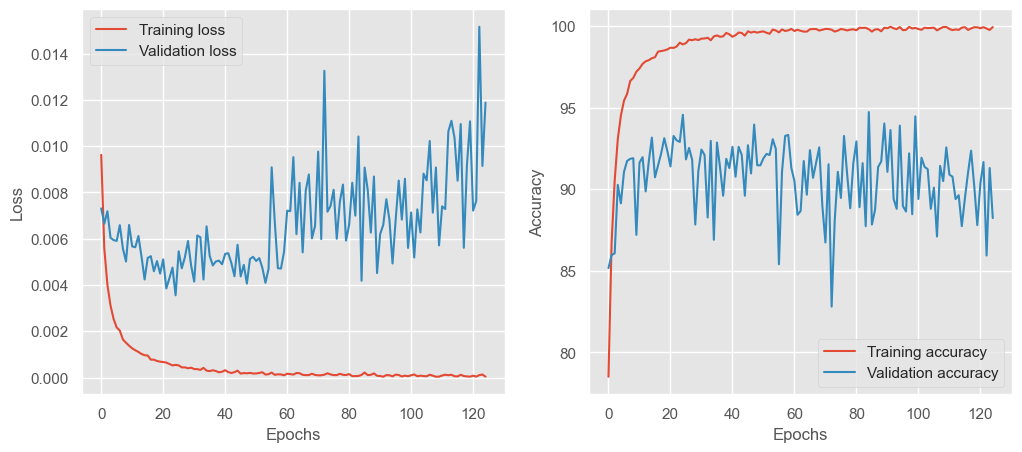

In [138]:
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy')
    plt.plot(val_accs, label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
print('Accuracy on val data: ', val_accs[-1])
print('Loss on val data: ', val_losses[-1])

plot_performance(train_losses, val_losses, train_accs, val_accs)

## Configuration 3: Different Pooling and Increased Dropout

In [145]:
# Create DataLoaders
batch_size = 512  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class CNN_Config3(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(CNN_Config3, self).__init__()
        self.n_sensors = n_sensors
        self.time_periods = time_periods
        self.n_classes = n_classes
        self.conv1 = nn.Conv1d(n_sensors, 200, kernel_size=10)
        self.conv2 = nn.Conv1d(200, 120, kernel_size=10)
        self.conv3 = nn.Conv1d(120, 160, kernel_size=10)
        self.avgpool = nn.AvgPool1d(3)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.6)
        self.fc = nn.Linear(160, n_classes)

    def forward(self, x):
        x = x.view(-1, self.n_sensors, self.time_periods)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.avgpool(x)
        x = F.relu(self.conv3(x))
        x = self.adaptive_pool(x)
        x = self.dropout(x)
        x = x.view(-1, 160)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn_config3 = CNN_Config3(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn_config3.to(device)

# Print model summary
print(model_cnn_config3)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_cnn_config3.parameters(), lr=0.001)

BATCH_SIZE = 400
EPOCHS = 200

train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_loss = float('inf')
patience = 100
trigger_times = 0

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    global best_val_loss, trigger_times
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses.append(test_loss)
    val_accs.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            return True
    return False

for epoch in range(1, EPOCHS + 1):
    train(model_cnn_config3, device, train_loader, my_optimizer, epoch)
    if validate(model_cnn_config3, device, test_loader):
        break

CNN_Config3(
  (conv1): Conv1d(3, 200, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(200, 120, kernel_size=(10,), stride=(1,))
  (conv3): Conv1d(120, 160, kernel_size=(10,), stride=(1,))
  (avgpool): AvgPool1d(kernel_size=(3,), stride=(3,), padding=(0,))
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.6, inplace=False)
  (fc): Linear(in_features=160, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.001883 	Accuracy: 67.38%
Validation: Average loss: 0.0014, Accuracy: 2192/3000 (73.07%)
Train Epoch: 2 	Loss: 0.001170 	Accuracy: 77.86%
Validation: Average loss: 0.0012, Accuracy: 2480/3000 (82.67%)
Train Epoch: 3 	Loss: 0.000912 	Accuracy: 82.94%
Validation: Average loss: 0.0010, Accuracy: 2523/3000 (84.10%)
Train Epoch: 4 	Loss: 0.000751 	Accuracy: 86.03%
Validation: Average loss: 0.0010, Accuracy: 2516/3000 (83.87%)
Train Epoch: 5 	Loss: 0.000664 	Accuracy: 87.48%
Validation: Average loss: 0.0010, Accuracy: 2454/3000 (81.80%)
Train Epoch: 6 	Loss: 0.0

Accuracy on val data:  90.83333333333333
Loss on val data:  0.0009590636864304543


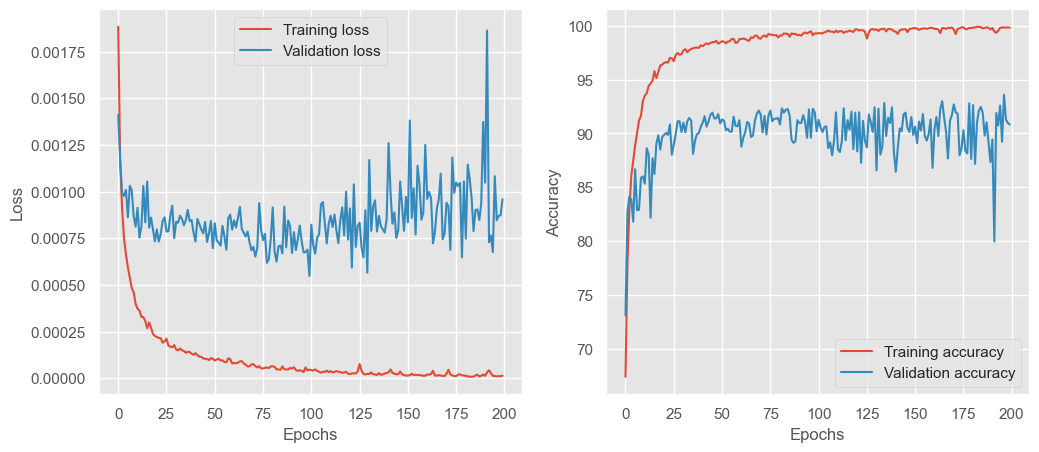

In [146]:
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy')
    plt.plot(val_accs, label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
print('Accuracy on val data: ', val_accs[-1])
print('Loss on val data: ', val_losses[-1])

plot_performance(train_losses, val_losses, train_accs, val_accs)

## Test CNN

[[258   1   0   0  29   0]
 [  3 963   0   0   3  40]
 [  0   0 223   0   0   0]
 [  0   0   9 137   3   0]
 [ 46   0   0   1 242   0]
 [  5  51   0   0  11 975]]


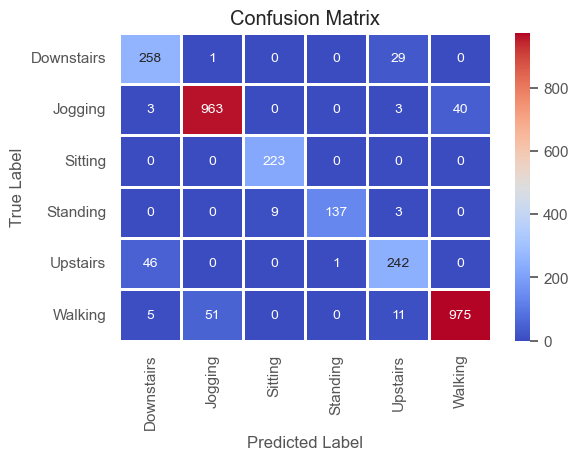

              precision    recall  f1-score   support

           0       0.83      0.90      0.86       288
           1       0.95      0.95      0.95      1009
           2       0.96      1.00      0.98       223
           3       0.99      0.92      0.95       149
           4       0.84      0.84      0.84       289
           5       0.96      0.94      0.95      1042

    accuracy                           0.93      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.93      0.93      0.93      3000


In [147]:
def show_confusion_matrix(validaitons, predictions, title=None):
    matrix = metrics.confusion_matrix(validaitons, predictions)
    
    print(matrix)
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    if title: plt.title(title)
    else: plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Get the predictions and true labels
all_predictions = []
all_labels = []
for data, labels in test_loader:
    data = data.to(device)
    predictions = model_cnn_config1.predict(data)
    all_predictions.extend(predictions.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

show_confusion_matrix(all_labels, all_predictions)
print(classification_report(all_labels, all_predictions))

# 3 Reflections of the Implementation and Experimentation

## 3.1 Data Augmentation

### 3.1.a Noise Addition

In [148]:
def add_noise(data, noise_level=0.01):
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

In [149]:
# Apply noise addition
noise_level = 0.05
x_train_noisy = add_noise(x_train, noise_level=noise_level)
x_train_augmented = np.concatenate((x_train, x_train_noisy), axis=0)
y_train_augmented = np.concatenate((y_train, y_train), axis=0)

# Convert your numpy arrays to PyTorch tensors
x_train_noisy_tensor = torch.tensor(x_train_augmented, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_augmented, dtype=torch.long)  # long for CrossEntropyLoss
x_validate_tensor = torch.tensor(x_validate, dtype=torch.float32)
y_validate_tensor = torch.tensor(y_validate, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_dataset_noisy = TensorDataset(x_train_noisy_tensor, y_train_tensor)
validate_dataset = TensorDataset(x_validate_tensor, y_validate_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 64  # You can change this value as per your need
train_loader_noisy = DataLoader(train_dataset_noisy, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [150]:
class CNN_Config1(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(CNN_Config1, self).__init__()
        self.n_sensors = n_sensors
        self.time_periods = time_periods
        self.n_classes = n_classes
        self.conv1 = nn.Conv1d(n_sensors, 64, kernel_size=5)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5)
        self.maxpool = nn.MaxPool1d(2)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, n_classes)

    def forward(self, x):
        x = x.view(-1, self.n_sensors, self.time_periods)
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.adaptive_pool(x)
        x = self.dropout(x)
        x = x.view(-1, 128)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn_config1 = CNN_Config1(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn_config1.to(device)

# Print model summary
print(model_cnn_config1)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_cnn_config1.parameters(), lr=0.001)

BATCH_SIZE = 64
EPOCHS = 500

train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_loss = float('inf')
patience = 100
trigger_times = 0

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    global best_val_loss, trigger_times
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses.append(test_loss)
    val_accs.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            return True
    return False

for epoch in range(1, EPOCHS + 1):
    train(model_cnn_config1, device, train_loader_noisy, my_optimizer, epoch)
    if validate(model_cnn_config1, device, test_loader):
        break

CNN_Config1(
  (conv1): Conv1d(3, 64, kernel_size=(5,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.010395 	Accuracy: 76.43%
Validation: Average loss: 0.0077, Accuracy: 2591/3000 (86.37%)
Train Epoch: 2 	Loss: 0.006395 	Accuracy: 84.91%
Validation: Average loss: 0.0065, Accuracy: 2619/3000 (87.30%)
Train Epoch: 3 	Loss: 0.005332 	Accuracy: 87.51%
Validation: Average loss: 0.0073, Accuracy: 2489/3000 (82.97%)
Train Epoch: 4 	Loss: 0.004712 	Accuracy: 88.80%
Validation: Average loss: 0.0083, Accuracy: 2508/3000 (83.60%)
Train Epoch: 5 	Loss: 0.004278 	Accuracy: 90.01%
Validation: Average loss: 0.0079, Accuracy: 2446/3000 (81.53%)
Train Epoch: 6 	Loss: 0.003932 	Accuracy: 91.07%
Validation: Average 

Accuracy on val data:  93.66666666666667
Loss on val data:  0.004749961098074626


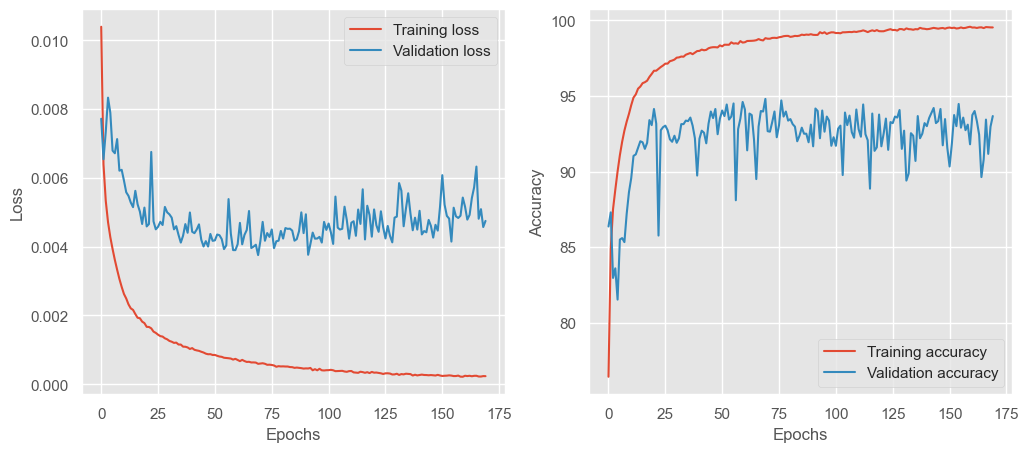

[[247   1   0   0  40   0]
 [  1 956   0   0   5  47]
 [  0   0 223   0   0   0]
 [  0   0   1 138  10   0]
 [ 36   0   0   1 252   0]
 [  2  18   0   0  28 994]]


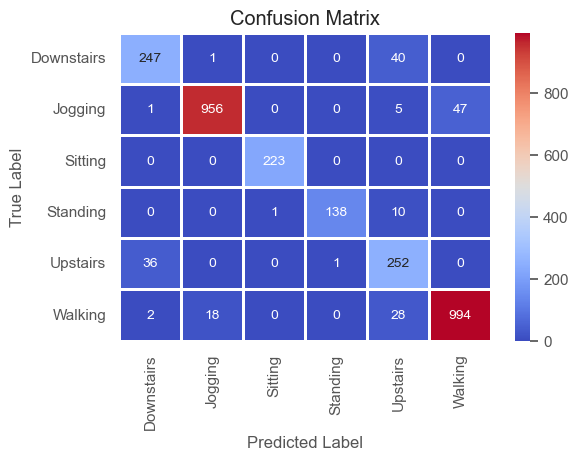

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       288
           1       0.98      0.95      0.96      1009
           2       1.00      1.00      1.00       223
           3       0.99      0.93      0.96       149
           4       0.75      0.87      0.81       289
           5       0.95      0.95      0.95      1042

    accuracy                           0.94      3000
   macro avg       0.92      0.93      0.92      3000
weighted avg       0.94      0.94      0.94      3000


In [153]:
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy')
    plt.plot(val_accs, label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
print('Accuracy on val data: ', val_accs[-1])
print('Loss on val data: ', val_losses[-1])

plot_performance(train_losses, val_losses, train_accs, val_accs)

def show_confusion_matrix(validaitons, predictions, title=None):
    matrix = metrics.confusion_matrix(validaitons, predictions)
    
    print(matrix)
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    if title: plt.title(title)
    else: plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Get the predictions and true labels
all_predictions = []
all_labels = []
for data, labels in test_loader:
    data = data.to(device)
    predictions = model_cnn_config1.predict(data)
    all_predictions.extend(predictions.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

show_confusion_matrix(all_labels, all_predictions)
print(classification_report(all_labels, all_predictions))

### 3.1.b Time Shifting

In [156]:
def time_shift(data, shift_steps):
    shifted_data = np.roll(data, shift=shift_steps, axis=1)
    return shifted_data

In [161]:
# Apply time shifting
shift_steps = 10  
x_train_shifted = time_shift(x_train, shift_steps=shift_steps)

# x_train_augmented = np.concatenate((x_train, x_train_shifted), axis=0)
# y_train_augmented = np.concatenate((y_train, y_train), axis=0)

# Convert your numpy arrays to PyTorch tensors
x_train_shifted_tensor = torch.tensor(x_train_shifted, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # long for CrossEntropyLoss
x_validate_tensor = torch.tensor(x_validate, dtype=torch.float32)
y_validate_tensor = torch.tensor(y_validate, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_dataset_shifted = TensorDataset(x_train_shifted_tensor, y_train_tensor)
validate_dataset = TensorDataset(x_validate_tensor, y_validate_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 64  # You can change this value as per your need
train_loader_shifted = DataLoader(train_dataset_shifted, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [162]:
class CNN_Config1(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(CNN_Config1, self).__init__()
        self.n_sensors = n_sensors
        self.time_periods = time_periods
        self.n_classes = n_classes
        self.conv1 = nn.Conv1d(n_sensors, 64, kernel_size=5)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5)
        self.maxpool = nn.MaxPool1d(2)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, n_classes)

    def forward(self, x):
        x = x.view(-1, self.n_sensors, self.time_periods)
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.adaptive_pool(x)
        x = self.dropout(x)
        x = x.view(-1, 128)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn_config1 = CNN_Config1(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn_config1.to(device)

# Print model summary
print(model_cnn_config1)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_cnn_config1.parameters(), lr=0.001)

BATCH_SIZE = 64
EPOCHS = 500

train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_loss = float('inf')
patience = 100
trigger_times = 0

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    global best_val_loss, trigger_times
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses.append(test_loss)
    val_accs.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            return True
    return False

for epoch in range(1, EPOCHS + 1):
    train(model_cnn_config1, device, train_loader_shifted, my_optimizer, epoch)
    if validate(model_cnn_config1, device, test_loader):
        break

CNN_Config1(
  (conv1): Conv1d(3, 64, kernel_size=(5,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.012918 	Accuracy: 71.16%
Validation: Average loss: 0.0093, Accuracy: 2358/3000 (78.60%)
Train Epoch: 2 	Loss: 0.008312 	Accuracy: 80.47%
Validation: Average loss: 0.0074, Accuracy: 2468/3000 (82.27%)
Train Epoch: 3 	Loss: 0.007012 	Accuracy: 83.26%
Validation: Average loss: 0.0070, Accuracy: 2513/3000 (83.77%)
Train Epoch: 4 	Loss: 0.006087 	Accuracy: 85.08%
Validation: Average loss: 0.0069, Accuracy: 2533/3000 (84.43%)
Train Epoch: 5 	Loss: 0.005636 	Accuracy: 86.39%
Validation: Average loss: 0.0061, Accuracy: 2657/3000 (88.57%)
Train Epoch: 6 	Loss: 0.005176 	Accuracy: 87.50%
Validation: Average 

Accuracy on val data:  89.96666666666667
Loss on val data:  0.005900362420727068


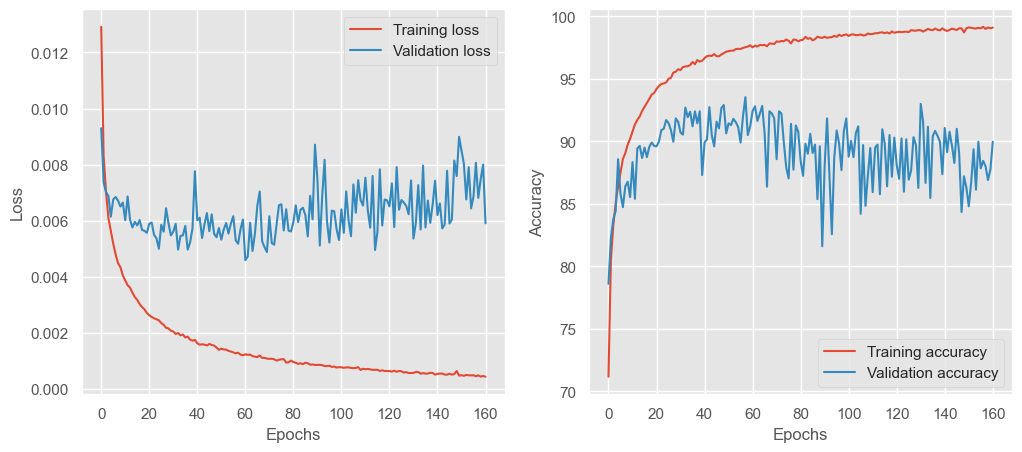

[[262   1   0   0  24   1]
 [  4 961   0   0   1  43]
 [  0   0 223   0   0   0]
 [  0   0   2 123  24   0]
 [ 48   0   1   2 236   2]
 [  4 102   0   0  42 894]]


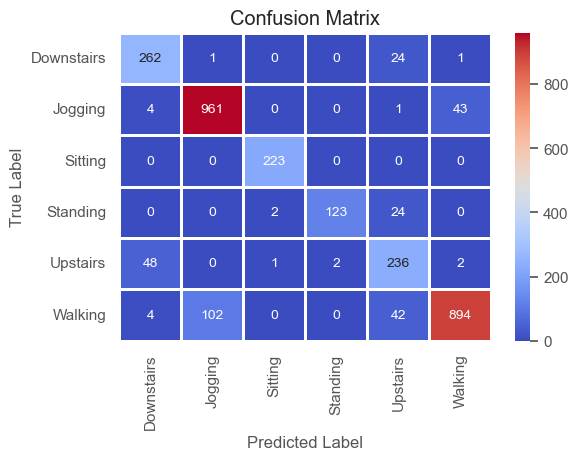

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       288
           1       0.90      0.95      0.93      1009
           2       0.99      1.00      0.99       223
           3       0.98      0.83      0.90       149
           4       0.72      0.82      0.77       289
           5       0.95      0.86      0.90      1042

    accuracy                           0.90      3000
   macro avg       0.90      0.89      0.89      3000
weighted avg       0.90      0.90      0.90      3000


In [163]:
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy')
    plt.plot(val_accs, label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
print('Accuracy on val data: ', val_accs[-1])
print('Loss on val data: ', val_losses[-1])

plot_performance(train_losses, val_losses, train_accs, val_accs)

def show_confusion_matrix(validaitons, predictions, title=None):
    matrix = metrics.confusion_matrix(validaitons, predictions)
    
    print(matrix)
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    if title: plt.title(title)
    else: plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Get the predictions and true labels
all_predictions = []
all_labels = []
for data, labels in test_loader:
    data = data.to(device)
    predictions = model_cnn_config1.predict(data)
    all_predictions.extend(predictions.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

show_confusion_matrix(all_labels, all_predictions)
print(classification_report(all_labels, all_predictions))

###  3.1.d Under Sampling (Random Elimination)

In [306]:
LABEL = 'ActivityEncoded'

le = preprocessing.LabelEncoder()  # string to Integer
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

df_train = df[df['user'] <= 28]
df_validate = df[df['user'].isin([31,30,29])]   # selects a portion of the data from df_train for validation purposes 
df_test = df[df['user'] > 32]

df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()

df_validate['x-axis'] = df_validate['x-axis'] / df_validate['x-axis'].max()
df_validate['y-axis'] = df_validate['y-axis'] / df_validate['y-axis'].max()
df_validate['z-axis'] = df_validate['z-axis'] / df_validate['z-axis'].max()

df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()

# round numbers
df_train = df_train.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})
df_validate = df_validate.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})
df_test = df_test.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})


import random

def randomly_eliminate_samples(df, target_counts):
    """
    Randomly eliminates samples from overrepresented classes to balance the dataset.
    
    Parameters:
        df (DataFrame): The original dataframe.
        target_counts (dict): A dictionary with class labels as keys and target counts as values.
    
    Returns:
        DataFrame: A balanced dataframe after random elimination.
    """
    balanced_df = pd.DataFrame()
    for label, target_count in target_counts.items():
        df_class = df[df[LABEL] == label]
        if len(df_class) > target_count:
            # Randomly select samples to keep
            df_class = df_class.sample(n=target_count, random_state=42)
        balanced_df = pd.concat([balanced_df, df_class])
    return balanced_df

# Calculate the target number of samples based on the least frequent class
min_count = df_train[LABEL].value_counts().min()
target_counts = {label: min_count for label in df_train[LABEL].unique()}

# Apply random elimination to balance the training dataset
df_train_balanced = randomly_eliminate_samples(df_train, target_counts)

def create_segments_and_labels(df, time_steps, step, label_name):
    # x, y, z acceleration as features
    N_FEATURES = 3

    # Number of steps to advance in each iteration
    # step = time_steps # no overlap between segments

    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]

        # find the most often used label in this segment
        label_mode_result = stats.mode(df[label_name][i: i + time_steps])
        if np.isscalar(label_mode_result.mode):
            label = label_mode_result.mode
        else:
            label = label_mode_result.mode[0]

        segments.append([xs, ys, zs])
        labels.append(label)

    # bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels  # x, y

# Define new time periods for downsampling
TIME_PERIODS = 80   # Adjust TIME_PERIODS for downsampling
STEP_DISTANCE = 40  # Adjust STEP_DISTANCE for downsampling

x_train, y_train = create_segments_and_labels(df_train_balanced,
                                              TIME_PERIODS,  # Adjust TIME_PERIODS accordingly
                                              STEP_DISTANCE,  # Adjust STEP_DISTANCE accordingly
                                              LABEL)

x_validate, y_validate = create_segments_and_labels(df_validate,
                                                    TIME_PERIODS,
                                                    STEP_DISTANCE,
                                                    LABEL)  # LABEL = 'ActivityEncoded'

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

# input, output dimensions
n_time_periods, n_sensors = x_train.shape[1], x_train.shape[2]
n_classes = le.classes_.size

input_shape = (n_time_periods * n_sensors)

x_train = x_train.reshape(x_train.shape[0], input_shape)
x_validate = x_validate.reshape(x_validate.shape[0], input_shape)
x_test =  x_test.reshape(x_test.shape[0], input_shape)

x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

x_validate = x_validate.astype('float32')
y_validate = y_validate.astype('float32')

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

def to_categorical(y, num_classes):
    return torch.eye(num_classes)[y]

n_classes = len(np.unique(y_train))  # Assuming y_train is available and contains your class labels
y_train_hot = to_categorical(y_train, n_classes)

# Convert your numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # long for CrossEntropyLoss
x_validate_tensor = torch.tensor(x_validate, dtype=torch.float32)
y_validate_tensor = torch.tensor(y_validate, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
validate_dataset = TensorDataset(x_validate_tensor, y_validate_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 64  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("x_train.shape", x_train.shape)
print("y_train.shape", y_train.shape)

x_train.shape (5017, 240)
y_train.shape (5017,)


In [307]:
df_train_balanced.activity.value_counts()

activity
Walking       33457
Jogging       33457
Upstairs      33457
Downstairs    33457
Sitting       33457
Standing      33457
Name: count, dtype: int64

CNN_Config1(
  (conv1): Conv1d(3, 64, kernel_size=(2,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(2,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.022882 	Accuracy: 43.89%
Validation: Average loss: 0.0224, Accuracy: 1204/3000 (40.13%)
Train Epoch: 2 	Loss: 0.011882 	Accuracy: 68.85%
Validation: Average loss: 0.0295, Accuracy: 621/3000 (20.70%)
Train Epoch: 3 	Loss: 0.008750 	Accuracy: 75.54%
Validation: Average loss: 0.0375, Accuracy: 719/3000 (23.97%)
Train Epoch: 4 	Loss: 0.007465 	Accuracy: 79.81%
Validation: Average loss: 0.0534, Accuracy: 578/3000 (19.27%)
Train Epoch: 5 	Loss: 0.006698 	Accuracy: 81.96%
Validation: Average loss: 0.0551, Accuracy: 690/3000 (23.00%)
Train Epoch: 6 	Loss: 0.006177 	Accuracy: 83.62%
Validation: Average loss

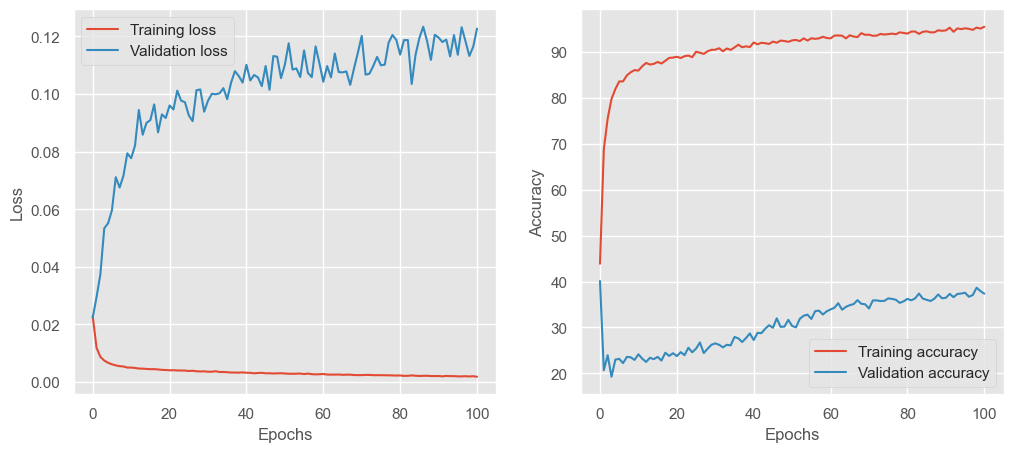

In [304]:
class CNN_Config1(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(CNN_Config1, self).__init__()
        self.n_sensors = n_sensors
        self.time_periods = time_periods
        self.n_classes = n_classes
        self.conv1 = nn.Conv1d(n_sensors, 64, kernel_size=2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=2)
        self.maxpool = nn.MaxPool1d(2)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, n_classes)

    def forward(self, x):
        x = x.view(-1, self.n_sensors, self.time_periods)
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.adaptive_pool(x)
        x = self.dropout(x)
        x = x.view(-1, 128)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn_config1 = CNN_Config1(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn_config1.to(device)

# Print model summary
print(model_cnn_config1)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_cnn_config1.parameters(), lr=0.001)

BATCH_SIZE = 64
EPOCHS = 500

train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_loss = float('inf')
patience = 100
trigger_times = 0

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    global best_val_loss, trigger_times
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses.append(test_loss)
    val_accs.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            return True
    return False

for epoch in range(1, EPOCHS + 1):
    train(model_cnn_config1, device, train_loader, my_optimizer, epoch)
    if validate(model_cnn_config1, device, test_loader):
        break
        
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy')
    plt.plot(val_accs, label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
print('Accuracy on val data: ', val_accs[-1])
print('Loss on val data: ', val_losses[-1])

plot_performance(train_losses, val_losses, train_accs, val_accs)

## 3.2 Baseline Comparison

### 3.2.a  Random Baseline

In [87]:
import numpy as np

def random_baseline_predict(class_counts, num_predictions):
    
    labels, counts = zip(*class_counts.items())
    total_count = sum(counts)
    probabilities = [count / total_count for count in counts]
    
    # Use np.random.choice to generate random predictions based on the probabilities
    predictions = np.random.choice(labels, size=num_predictions, p=probabilities)
    
    return predictions

# Example usage:
class_counts = df.activity.value_counts().to_dict()

num_predictions = 200  # Number of random predictions you want to generate
random_predictions = random_baseline_predict(class_counts, num_predictions)
print(random_predictions)

['Jogging' 'Walking' 'Sitting' 'Jogging' 'Walking' 'Jogging' 'Walking'
 'Standing' 'Walking' 'Standing' 'Standing' 'Walking' 'Upstairs'
 'Standing' 'Jogging' 'Jogging' 'Standing' 'Walking' 'Downstairs'
 'Jogging' 'Walking' 'Walking' 'Upstairs' 'Walking' 'Jogging' 'Jogging'
 'Sitting' 'Walking' 'Upstairs' 'Downstairs' 'Jogging' 'Upstairs'
 'Jogging' 'Sitting' 'Walking' 'Upstairs' 'Upstairs' 'Walking' 'Upstairs'
 'Jogging' 'Walking' 'Jogging' 'Walking' 'Jogging' 'Walking' 'Upstairs'
 'Jogging' 'Walking' 'Jogging' 'Walking' 'Walking' 'Upstairs' 'Jogging'
 'Walking' 'Jogging' 'Jogging' 'Walking' 'Jogging' 'Jogging' 'Walking'
 'Jogging' 'Walking' 'Jogging' 'Upstairs' 'Jogging' 'Downstairs'
 'Downstairs' 'Walking' 'Upstairs' 'Walking' 'Standing' 'Jogging'
 'Downstairs' 'Downstairs' 'Upstairs' 'Downstairs' 'Walking' 'Jogging'
 'Walking' 'Downstairs' 'Jogging' 'Walking' 'Standing' 'Jogging'
 'Downstairs' 'Walking' 'Jogging' 'Standing' 'Jogging' 'Walking' 'Jogging'
 'Sitting' 'Jogging' 'Walking

In [89]:
def calculate_accuracy(true_labels, predictions):
    correct_predictions = sum(1 for true, pred in zip(true_labels, predictions) if true == pred)
    accuracy = correct_predictions / len(true_labels)
    return accuracy

true_labels = df.activity.values
num_predictions = len(true_labels)  # Number of predictions should match the number of true labels
random_predictions = random_baseline_predict(class_counts, num_predictions)

random_baseline_accuracy = calculate_accuracy(true_labels, random_predictions)
print(f"Random Baseline Accuracy: {random_baseline_accuracy * 100:.2f}%")

Random Baseline Accuracy: 27.19%


### 3.2.c Over fiting

In [210]:
# Create DataLoaders
batch_size = 512  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class CNN_Config1(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(CNN_Config1, self).__init__()
        self.n_sensors = n_sensors
        self.time_periods = time_periods
        self.n_classes = n_classes
        self.conv1 = nn.Conv1d(n_sensors, 64, kernel_size=5)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5)
        self.maxpool = nn.MaxPool1d(2)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, n_classes)

    def forward(self, x):
        x = x.view(-1, self.n_sensors, self.time_periods)
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.adaptive_pool(x)
        x = self.dropout(x)
        x = x.view(-1, 128)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn_config1 = CNN_Config1(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn_config1.to(device)

# Print model summary
print(model_cnn_config1)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_cnn_config1.parameters(), lr=0.01)

BATCH_SIZE = 64
EPOCHS = 500

train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_loss = float('inf')
patience = 500
trigger_times = 0

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    global best_val_loss, trigger_times
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses.append(test_loss)
    val_accs.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            return True
    return False

for epoch in range(1, EPOCHS + 1):
    train(model_cnn_config1, device, train_loader, my_optimizer, epoch)
    if validate(model_cnn_config1, device, test_loader):
        break

CNN_Config1(
  (conv1): Conv1d(3, 64, kernel_size=(5,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.001594 	Accuracy: 71.76%
Validation: Average loss: 0.0012, Accuracy: 3146/3888 (80.92%)
Train Epoch: 2 	Loss: 0.000975 	Accuracy: 81.55%
Validation: Average loss: 0.0010, Accuracy: 3242/3888 (83.38%)
Train Epoch: 3 	Loss: 0.000782 	Accuracy: 85.48%
Validation: Average loss: 0.0011, Accuracy: 3234/3888 (83.18%)
Train Epoch: 4 	Loss: 0.000661 	Accuracy: 87.60%
Validation: Average loss: 0.0009, Accuracy: 3384/3888 (87.04%)
Train Epoch: 5 	Loss: 0.000574 	Accuracy: 89.44%
Validation: Average loss: 0.0009, Accuracy: 3374/3888 (86.78%)
Train Epoch: 6 	Loss: 0.000522 	Accuracy: 90.53%
Validation: Average 

Accuracy on val data:  90.50925925925925
Loss on val data:  0.0013720965005242776


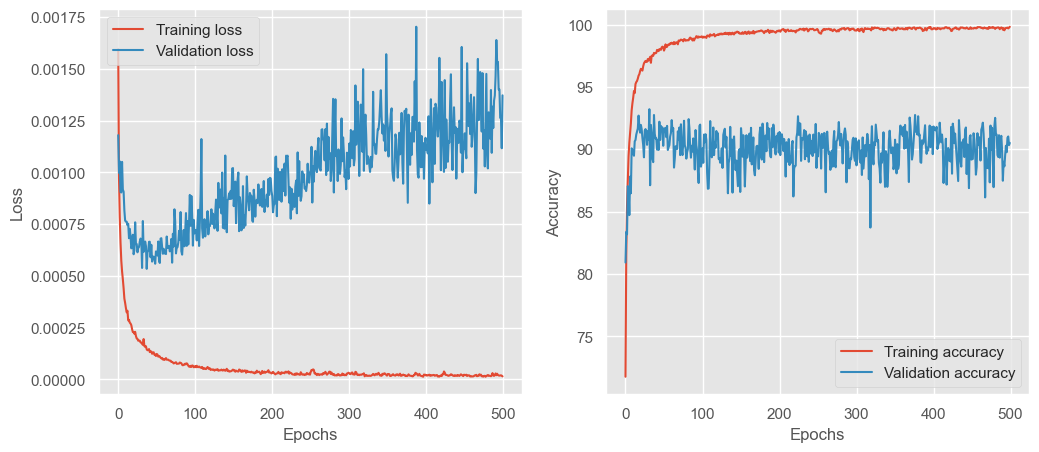

In [211]:
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy')
    plt.plot(val_accs, label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
print('Accuracy on val data: ', val_accs[-1])
print('Loss on val data: ', val_losses[-1])

plot_performance(train_losses, val_losses, train_accs, val_accs)

## 3.3. Batch Normalization and Layer Normalization

In [215]:
# Create DataLoaders
batch_size = 64  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class CNN_Config1(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(CNN_Config1, self).__init__()
        self.n_sensors = n_sensors
        self.time_periods = time_periods
        self.n_classes = n_classes
        self.conv1 = nn.Conv1d(n_sensors, 64, kernel_size=5)
        self.bn1 = nn.BatchNorm1d(64)  # Batch Normalization after Conv1
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5)
        self.bn2 = nn.BatchNorm1d(128)  # Batch Normalization after Conv2
        self.maxpool = nn.MaxPool1d(2)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, n_classes)
        self.ln = nn.LayerNorm(128)  # Layer Normalization before the fully connected layer

    def forward(self, x):
        x = x.view(-1, self.n_sensors, self.time_periods)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.adaptive_pool(x)
        x = self.dropout(x)
        x = x.view(-1, 128)
        x = self.ln(x)  # Apply Layer Normalization
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn_config1 = CNN_Config1(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn_config1.to(device)

# Print model summary
print(model_cnn_config1)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_cnn_config1.parameters(), lr=0.001)

BATCH_SIZE = 64
EPOCHS = 500

train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_loss = float('inf')
patience = 100
trigger_times = 0

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    global best_val_loss, trigger_times
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses.append(test_loss)
    val_accs.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            return True
    return False

for epoch in range(1, EPOCHS + 1):
    train(model_cnn_config1, device, train_loader, my_optimizer, epoch)
    if validate(model_cnn_config1, device, test_loader):
        break

CNN_Config1(
  (conv1): Conv1d(3, 64, kernel_size=(5,), stride=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
  (ln): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
)
Train Epoch: 1 	Loss: 0.008240 	Accuracy: 82.28%
Validation: Average loss: 0.0060, Accuracy: 3520/3888 (90.53%)
Train Epoch: 2 	Loss: 0.004506 	Accuracy: 90.48%
Validation: Average loss: 0.0053, Accuracy: 3641/3888 (93.65%)
Train Epoch: 3 	Loss: 0.003669 	Accuracy: 92.30%
Validation: Average loss: 0.0073, Accuracy: 3532/3888 (90.84%)
Train Epoch: 4 	Loss: 0.003216 	Accuracy: 93.04%
Val

Accuracy on val data:  93.69855967078189
Loss on val data:  0.009023501397928228


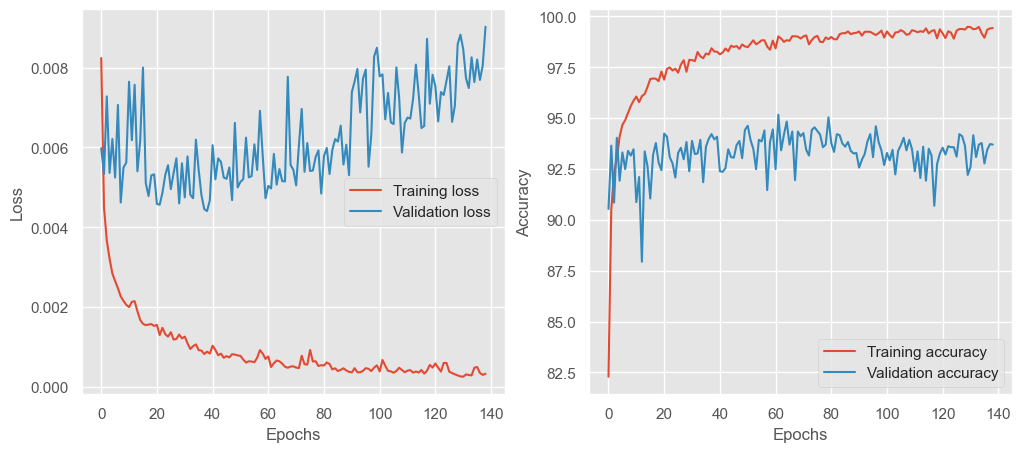

[[ 304    5    0    1   30    8]
 [  24 1241    0    0    9   40]
 [   0    0  300    0    0    0]
 [   0    1    2  187    0    1]
 [  54    0    0    1  279   49]
 [  16    2    0    0    2 1332]]


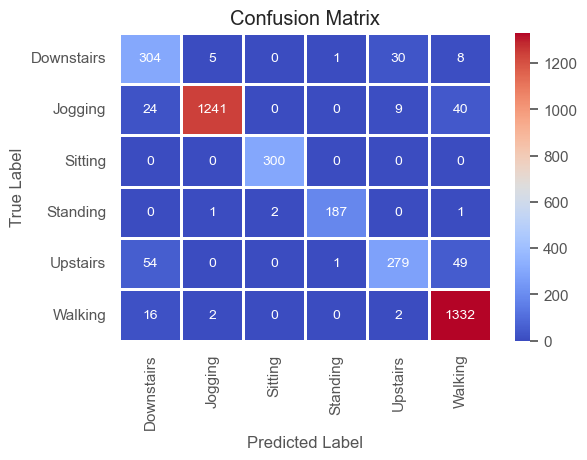

              precision    recall  f1-score   support

           0       0.76      0.87      0.82       348
           1       0.99      0.94      0.97      1314
           2       0.99      1.00      1.00       300
           3       0.99      0.98      0.98       191
           4       0.87      0.73      0.79       383
           5       0.93      0.99      0.96      1352

    accuracy                           0.94      3888
   macro avg       0.92      0.92      0.92      3888
weighted avg       0.94      0.94      0.94      3888


In [219]:
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy')
    plt.plot(val_accs, label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
print('Accuracy on val data: ', val_accs[-1])
print('Loss on val data: ', val_losses[-1])

plot_performance(train_losses, val_losses, train_accs, val_accs)

def show_confusion_matrix(validaitons, predictions, title=None):
    matrix = metrics.confusion_matrix(validaitons, predictions)
    
    print(matrix)
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    if title: plt.title(title)
    else: plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Get the predictions and true labels
all_predictions = []
all_labels = []
for data, labels in test_loader:
    data = data.to(device)
    predictions = model_cnn_config1.predict(data)
    all_predictions.extend(predictions.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

show_confusion_matrix(all_labels, all_predictions)
print(classification_report(all_labels, all_predictions))

## 3.4. Optimizations

CNN_Config1(
  (conv1): Conv1d(3, 64, kernel_size=(5,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.012616 	Accuracy: 75.15%
Validation: Average loss: 0.0142, Accuracy: 3215/3888 (82.69%)
Train Epoch: 2 	Loss: 0.008577 	Accuracy: 81.29%
Validation: Average loss: 0.0069, Accuracy: 3418/3888 (87.91%)
Train Epoch: 3 	Loss: 0.006725 	Accuracy: 85.15%
Validation: Average loss: 0.0072, Accuracy: 3444/3888 (88.58%)
Train Epoch: 4 	Loss: 0.006314 	Accuracy: 85.76%
Validation: Average loss: 0.0069, Accuracy: 3358/3888 (86.37%)
Train Epoch: 5 	Loss: 0.007896 	Accuracy: 83.55%
Validation: Average loss: 0.0084, Accuracy: 3446/3888 (88.63%)
Train Epoch: 6 	Loss: 0.007566 	Accuracy: 84.00%
Validation: Average 

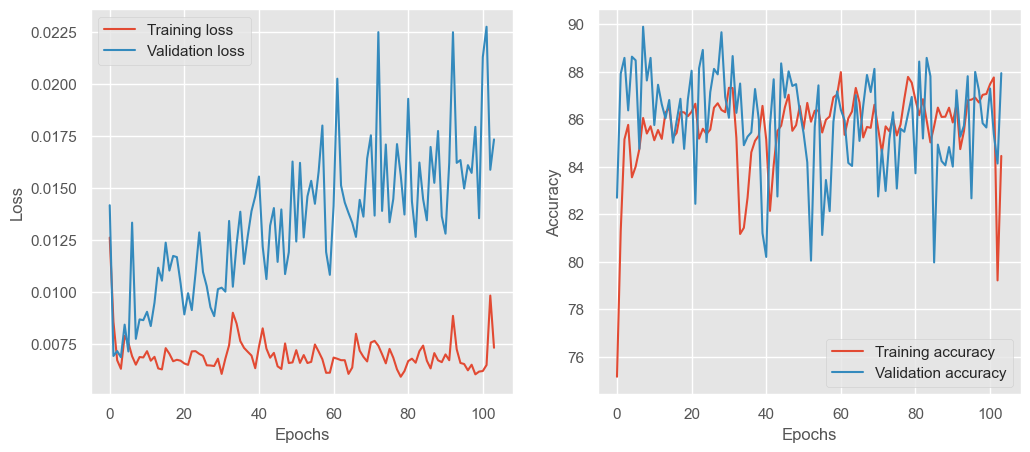

In [227]:
# Create DataLoaders
batch_size = 64  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class CNN_Config1(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(CNN_Config1, self).__init__()
        self.n_sensors = n_sensors
        self.time_periods = time_periods
        self.n_classes = n_classes
        self.conv1 = nn.Conv1d(n_sensors, 64, kernel_size=5)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5)
        self.maxpool = nn.MaxPool1d(2)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, n_classes)

    def forward(self, x):
        x = x.view(-1, self.n_sensors, self.time_periods)
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.adaptive_pool(x)
        x = self.dropout(x)
        x = x.view(-1, 128)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn_config1 = CNN_Config1(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn_config1.to(device)

# Print model summary
print(model_cnn_config1)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_cnn_config1.parameters(), lr=0.1)

BATCH_SIZE = 64
EPOCHS = 500

train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_loss = float('inf')
patience = 100
trigger_times = 0

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    global best_val_loss, trigger_times
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses.append(test_loss)
    val_accs.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            return True
    return False

for epoch in range(1, EPOCHS + 1):
    train(model_cnn_config1, device, train_loader, my_optimizer, epoch)
    if validate(model_cnn_config1, device, test_loader):
        break
        
       
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy')
    plt.plot(val_accs, label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
print('Accuracy on val data: ', val_accs[-1])
print('Loss on val data: ', val_losses[-1])

plot_performance(train_losses, val_losses, train_accs, val_accs)

CNN_Config1(
  (conv1): Conv1d(3, 64, kernel_size=(5,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.008528 	Accuracy: 80.68%
Validation: Average loss: 0.0095, Accuracy: 3191/3888 (82.07%)
Train Epoch: 2 	Loss: 0.005098 	Accuracy: 88.10%
Validation: Average loss: 0.0075, Accuracy: 3405/3888 (87.58%)
Train Epoch: 3 	Loss: 0.003950 	Accuracy: 91.17%
Validation: Average loss: 0.0076, Accuracy: 3394/3888 (87.29%)
Train Epoch: 4 	Loss: 0.002904 	Accuracy: 93.56%
Validation: Average loss: 0.0056, Accuracy: 3490/3888 (89.76%)
Train Epoch: 5 	Loss: 0.002520 	Accuracy: 94.64%
Validation: Average loss: 0.0050, Accuracy: 3569/3888 (91.80%)
Train Epoch: 6 	Loss: 0.002263 	Accuracy: 95.17%
Validation: Average 

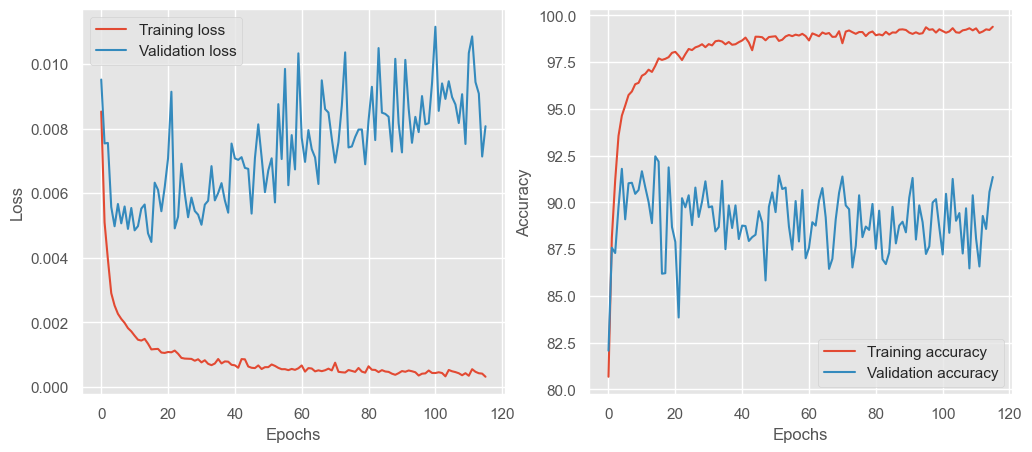

In [228]:
# Create DataLoaders
batch_size = 64  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class CNN_Config1(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(CNN_Config1, self).__init__()
        self.n_sensors = n_sensors
        self.time_periods = time_periods
        self.n_classes = n_classes
        self.conv1 = nn.Conv1d(n_sensors, 64, kernel_size=5)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5)
        self.maxpool = nn.MaxPool1d(2)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, n_classes)

    def forward(self, x):
        x = x.view(-1, self.n_sensors, self.time_periods)
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.adaptive_pool(x)
        x = self.dropout(x)
        x = x.view(-1, 128)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn_config1 = CNN_Config1(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn_config1.to(device)

# Print model summary
print(model_cnn_config1)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_cnn_config1.parameters(), lr=0.01)

BATCH_SIZE = 64
EPOCHS = 500

train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_loss = float('inf')
patience = 100
trigger_times = 0

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    global best_val_loss, trigger_times
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses.append(test_loss)
    val_accs.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            return True
    return False

for epoch in range(1, EPOCHS + 1):
    train(model_cnn_config1, device, train_loader, my_optimizer, epoch)
    if validate(model_cnn_config1, device, test_loader):
        break
        
       
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy')
    plt.plot(val_accs, label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
print('Accuracy on val data: ', val_accs[-1])
print('Loss on val data: ', val_losses[-1])

plot_performance(train_losses, val_losses, train_accs, val_accs)

CNN_Config1(
  (conv1): Conv1d(3, 64, kernel_size=(5,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.012545 	Accuracy: 72.49%
Validation: Average loss: 0.0087, Accuracy: 3141/3888 (80.79%)
Train Epoch: 2 	Loss: 0.007898 	Accuracy: 81.58%
Validation: Average loss: 0.0070, Accuracy: 3340/3888 (85.91%)
Train Epoch: 3 	Loss: 0.006672 	Accuracy: 84.00%
Validation: Average loss: 0.0064, Accuracy: 3391/3888 (87.22%)
Train Epoch: 4 	Loss: 0.005901 	Accuracy: 85.60%
Validation: Average loss: 0.0068, Accuracy: 3374/3888 (86.78%)
Train Epoch: 5 	Loss: 0.005532 	Accuracy: 86.83%
Validation: Average loss: 0.0066, Accuracy: 3335/3888 (85.78%)
Train Epoch: 6 	Loss: 0.005169 	Accuracy: 87.71%
Validation: Average 

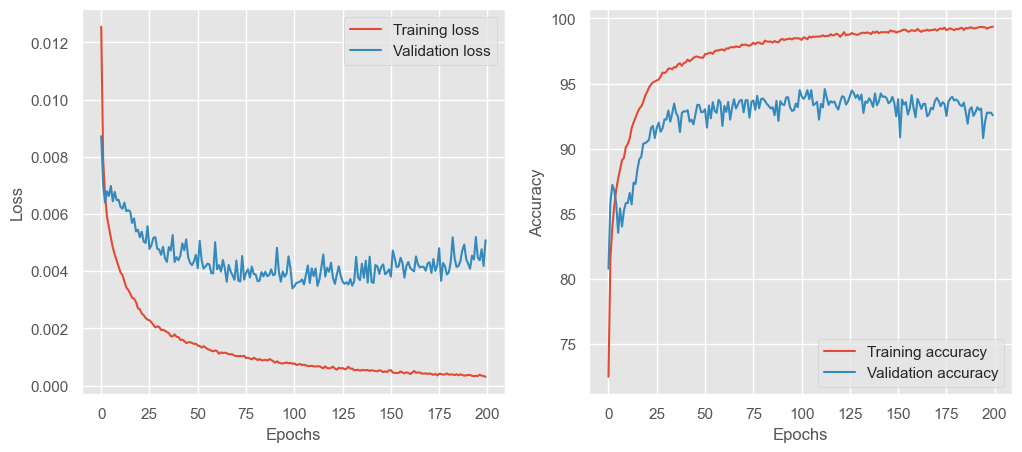

In [229]:
# Create DataLoaders
batch_size = 64  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class CNN_Config1(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(CNN_Config1, self).__init__()
        self.n_sensors = n_sensors
        self.time_periods = time_periods
        self.n_classes = n_classes
        self.conv1 = nn.Conv1d(n_sensors, 64, kernel_size=5)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5)
        self.maxpool = nn.MaxPool1d(2)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, n_classes)

    def forward(self, x):
        x = x.view(-1, self.n_sensors, self.time_periods)
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.adaptive_pool(x)
        x = self.dropout(x)
        x = x.view(-1, 128)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn_config1 = CNN_Config1(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn_config1.to(device)

# Print model summary
print(model_cnn_config1)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_cnn_config1.parameters(), lr=0.001)

BATCH_SIZE = 64
EPOCHS = 500

train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_loss = float('inf')
patience = 100
trigger_times = 0

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    global best_val_loss, trigger_times
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses.append(test_loss)
    val_accs.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            return True
    return False

for epoch in range(1, EPOCHS + 1):
    train(model_cnn_config1, device, train_loader, my_optimizer, epoch)
    if validate(model_cnn_config1, device, test_loader):
        break
        
       
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy')
    plt.plot(val_accs, label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
print('Accuracy on val data: ', val_accs[-1])
print('Loss on val data: ', val_losses[-1])

plot_performance(train_losses, val_losses, train_accs, val_accs)

CNN_Config1(
  (conv1): Conv1d(3, 64, kernel_size=(5,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.012904 	Accuracy: 74.15%
Validation: Average loss: 0.0084, Accuracy: 3105/3888 (79.86%)
Train Epoch: 2 	Loss: 0.010929 	Accuracy: 76.57%
Validation: Average loss: 0.0116, Accuracy: 2935/3888 (75.49%)
Train Epoch: 3 	Loss: 0.010618 	Accuracy: 74.31%
Validation: Average loss: 0.0091, Accuracy: 3241/3888 (83.36%)
Train Epoch: 4 	Loss: 0.008211 	Accuracy: 81.36%
Validation: Average loss: 0.0083, Accuracy: 3303/3888 (84.95%)
Train Epoch: 5 	Loss: 0.008560 	Accuracy: 80.68%
Validation: Average loss: 0.0090, Accuracy: 3339/3888 (85.88%)
Train Epoch: 6 	Loss: 0.008614 	Accuracy: 80.91%
Validation: Average 

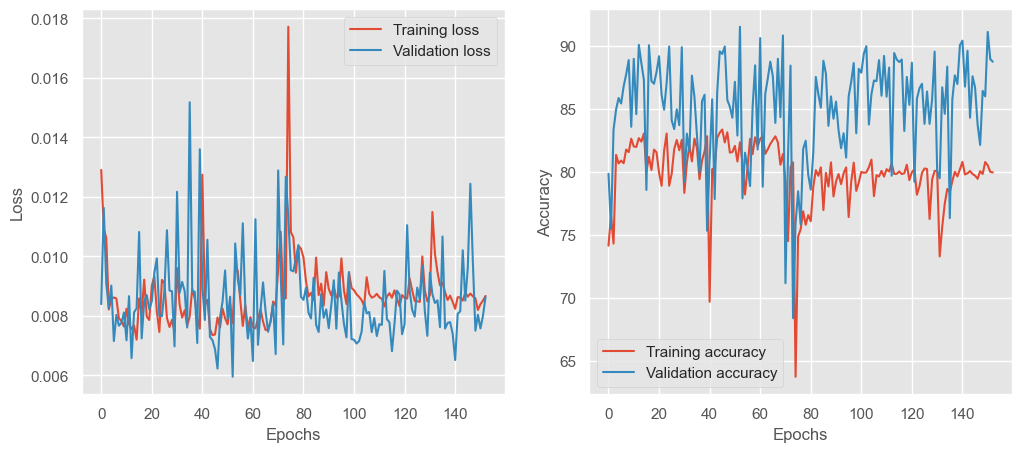

In [230]:
# Create DataLoaders
batch_size = 64  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class CNN_Config1(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(CNN_Config1, self).__init__()
        self.n_sensors = n_sensors
        self.time_periods = time_periods
        self.n_classes = n_classes
        self.conv1 = nn.Conv1d(n_sensors, 64, kernel_size=5)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5)
        self.maxpool = nn.MaxPool1d(2)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, n_classes)

    def forward(self, x):
        x = x.view(-1, self.n_sensors, self.time_periods)
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.adaptive_pool(x)
        x = self.dropout(x)
        x = x.view(-1, 128)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn_config1 = CNN_Config1(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn_config1.to(device)

# Print model summary
print(model_cnn_config1)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.AdamW(model_cnn_config1.parameters(), lr=0.1)

BATCH_SIZE = 64
EPOCHS = 500

train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_loss = float('inf')
patience = 100
trigger_times = 0

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    global best_val_loss, trigger_times
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses.append(test_loss)
    val_accs.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            return True
    return False

for epoch in range(1, EPOCHS + 1):
    train(model_cnn_config1, device, train_loader, my_optimizer, epoch)
    if validate(model_cnn_config1, device, test_loader):
        break
        
       
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy')
    plt.plot(val_accs, label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
print('Accuracy on val data: ', val_accs[-1])
print('Loss on val data: ', val_losses[-1])

plot_performance(train_losses, val_losses, train_accs, val_accs)

CNN_Config1(
  (conv1): Conv1d(3, 64, kernel_size=(5,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.008308 	Accuracy: 81.01%
Validation: Average loss: 0.0108, Accuracy: 3063/3888 (78.78%)
Train Epoch: 2 	Loss: 0.004889 	Accuracy: 88.97%
Validation: Average loss: 0.0067, Accuracy: 3338/3888 (85.85%)
Train Epoch: 3 	Loss: 0.003739 	Accuracy: 91.66%
Validation: Average loss: 0.0061, Accuracy: 3410/3888 (87.71%)
Train Epoch: 4 	Loss: 0.003170 	Accuracy: 93.24%
Validation: Average loss: 0.0061, Accuracy: 3423/3888 (88.04%)
Train Epoch: 5 	Loss: 0.002845 	Accuracy: 93.92%
Validation: Average loss: 0.0059, Accuracy: 3468/3888 (89.20%)
Train Epoch: 6 	Loss: 0.002442 	Accuracy: 95.03%
Validation: Average 

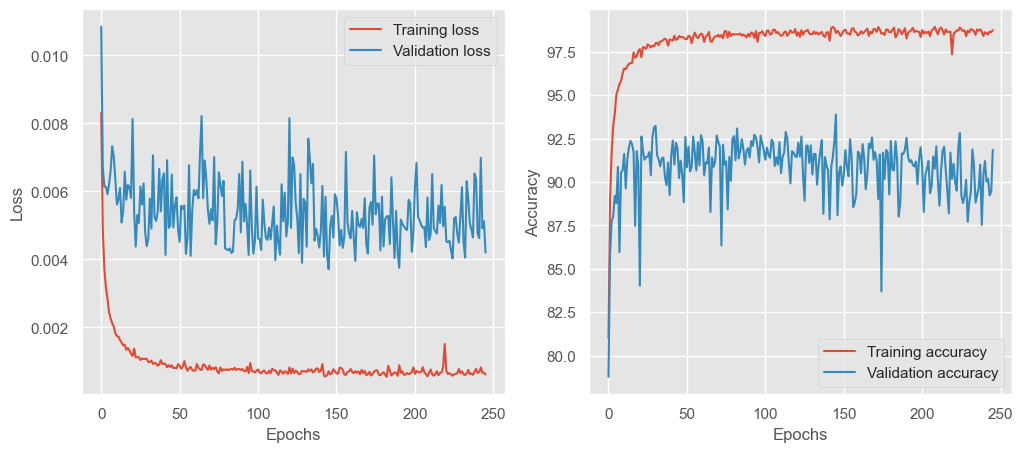

In [231]:
# Create DataLoaders
batch_size = 64  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class CNN_Config1(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(CNN_Config1, self).__init__()
        self.n_sensors = n_sensors
        self.time_periods = time_periods
        self.n_classes = n_classes
        self.conv1 = nn.Conv1d(n_sensors, 64, kernel_size=5)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5)
        self.maxpool = nn.MaxPool1d(2)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, n_classes)

    def forward(self, x):
        x = x.view(-1, self.n_sensors, self.time_periods)
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.adaptive_pool(x)
        x = self.dropout(x)
        x = x.view(-1, 128)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn_config1 = CNN_Config1(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn_config1.to(device)

# Print model summary
print(model_cnn_config1)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.AdamW(model_cnn_config1.parameters(), lr=0.01)

BATCH_SIZE = 64
EPOCHS = 500

train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_loss = float('inf')
patience = 100
trigger_times = 0

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    global best_val_loss, trigger_times
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses.append(test_loss)
    val_accs.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            return True
    return False

for epoch in range(1, EPOCHS + 1):
    train(model_cnn_config1, device, train_loader, my_optimizer, epoch)
    if validate(model_cnn_config1, device, test_loader):
        break
        
       
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy')
    plt.plot(val_accs, label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
print('Accuracy on val data: ', val_accs[-1])
print('Loss on val data: ', val_losses[-1])

plot_performance(train_losses, val_losses, train_accs, val_accs)

CNN_Config1(
  (conv1): Conv1d(3, 64, kernel_size=(5,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.012636 	Accuracy: 71.92%
Validation: Average loss: 0.0088, Accuracy: 3201/3888 (82.33%)
Train Epoch: 2 	Loss: 0.008091 	Accuracy: 81.29%
Validation: Average loss: 0.0077, Accuracy: 3247/3888 (83.51%)
Train Epoch: 3 	Loss: 0.006704 	Accuracy: 83.87%
Validation: Average loss: 0.0068, Accuracy: 3301/3888 (84.90%)
Train Epoch: 4 	Loss: 0.006043 	Accuracy: 85.73%
Validation: Average loss: 0.0065, Accuracy: 3393/3888 (87.27%)
Train Epoch: 5 	Loss: 0.005432 	Accuracy: 87.20%
Validation: Average loss: 0.0066, Accuracy: 3306/3888 (85.03%)
Train Epoch: 6 	Loss: 0.005071 	Accuracy: 88.26%
Validation: Average 

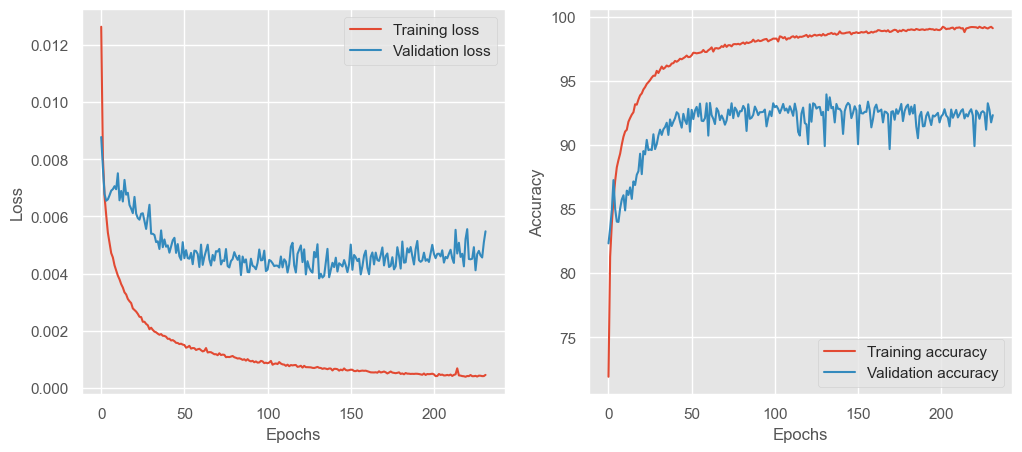

In [232]:
# Create DataLoaders
batch_size = 64  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class CNN_Config1(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(CNN_Config1, self).__init__()
        self.n_sensors = n_sensors
        self.time_periods = time_periods
        self.n_classes = n_classes
        self.conv1 = nn.Conv1d(n_sensors, 64, kernel_size=5)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5)
        self.maxpool = nn.MaxPool1d(2)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, n_classes)

    def forward(self, x):
        x = x.view(-1, self.n_sensors, self.time_periods)
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.adaptive_pool(x)
        x = self.dropout(x)
        x = x.view(-1, 128)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn_config1 = CNN_Config1(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn_config1.to(device)

# Print model summary
print(model_cnn_config1)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.AdamW(model_cnn_config1.parameters(), lr=0.001)

BATCH_SIZE = 64
EPOCHS = 500

train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_loss = float('inf')
patience = 100
trigger_times = 0

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    global best_val_loss, trigger_times
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses.append(test_loss)
    val_accs.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            return True
    return False

for epoch in range(1, EPOCHS + 1):
    train(model_cnn_config1, device, train_loader, my_optimizer, epoch)
    if validate(model_cnn_config1, device, test_loader):
        break
        
       
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy')
    plt.plot(val_accs, label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
print('Accuracy on val data: ', val_accs[-1])
print('Loss on val data: ', val_losses[-1])

plot_performance(train_losses, val_losses, train_accs, val_accs)

## 3.5 Model Scaling

### 3.5.a

In [234]:
# Create DataLoaders
batch_size = 64  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 1D Convolutional Neural Network
class CNN(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(CNN, self).__init__()
        self.n_sensors = n_sensors
        self.time_periods = time_periods
        self.n_classes = n_classes
        self.conv1 = nn.Conv1d(n_sensors, 50, kernel_size=10)
        self.conv2 = nn.Conv1d(50, 50, kernel_size=10)
        self.conv3 = nn.Conv1d(50, 80, kernel_size=10)
        self.conv4 = nn.Conv1d(80, 80, kernel_size=10)
        self.maxpool = nn.MaxPool1d(3)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(80, n_classes)

    def forward(self, x):
        x = x.view(-1, self.n_sensors, self.time_periods)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.adaptive_pool(x)
        x = self.dropout(x)
        x = x.view(-1, 80)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn = CNN(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn.to(device)

# Print model summary
print(model_cnn)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

BATCH_SIZE = 64
EPOCHS = 500

train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_loss = float('inf')
patience = 100
trigger_times = 0

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    global best_val_loss, trigger_times
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses.append(test_loss)
    val_accs.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            return True
    return False

for epoch in range(1, EPOCHS + 1):
    train(model_cnn, device, train_loader, my_optimizer, epoch)
    if validate(model_cnn, device, test_loader):
        break

CNN(
  (conv1): Conv1d(3, 50, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(50, 50, kernel_size=(10,), stride=(1,))
  (conv3): Conv1d(50, 80, kernel_size=(10,), stride=(1,))
  (conv4): Conv1d(80, 80, kernel_size=(10,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=80, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.009759 	Accuracy: 77.41%
Validation: Average loss: 0.0081, Accuracy: 3270/3888 (84.10%)
Train Epoch: 2 	Loss: 0.005208 	Accuracy: 87.37%
Validation: Average loss: 0.0057, Accuracy: 3354/3888 (86.27%)
Train Epoch: 3 	Loss: 0.003860 	Accuracy: 90.60%
Validation: Average loss: 0.0062, Accuracy: 3284/3888 (84.47%)
Train Epoch: 4 	Loss: 0.003185 	Accuracy: 92.65%
Validation: Average loss: 0.0056, Accuracy: 3400/3888 (87.45%)
Train Epoch: 5 	Loss: 0.002524 	Accuracy: 94.47%
Validation: Average loss

In [240]:
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy')
    plt.plot(val_accs, label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

print('Accuracy on val data: ', val_accs[-1])
print('Loss on val data: ', val_losses[-1])

plot_performance(train_losses, val_losses, train_accs, val_accs)

### 3.5.b

### reduce dropout to 0.3

In [237]:
# Create DataLoaders
batch_size = 64  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 1D Convolutional Neural Network
class CNN(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(CNN, self).__init__()
        self.n_sensors = n_sensors
        self.time_periods = time_periods
        self.n_classes = n_classes
        self.conv1 = nn.Conv1d(n_sensors, 100, kernel_size=10)
        self.conv2 = nn.Conv1d(100, 100, kernel_size=10)
        self.conv3 = nn.Conv1d(100, 160, kernel_size=10)
        self.conv4 = nn.Conv1d(160, 160, kernel_size=10)
        self.maxpool = nn.MaxPool1d(3)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(160, n_classes)

    def forward(self, x):
        x = x.view(-1, self.n_sensors, self.time_periods)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.adaptive_pool(x)
        x = self.dropout(x)
        x = x.view(-1, 160)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn = CNN(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn.to(device)

# Print model summary
print(model_cnn)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

BATCH_SIZE = 64
EPOCHS = 500

train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_loss = float('inf')
patience = 100
trigger_times = 0

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    global best_val_loss, trigger_times
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses.append(test_loss)
    val_accs.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            return True
    return False

for epoch in range(1, EPOCHS + 1):
    train(model_cnn, device, train_loader, my_optimizer, epoch)
    if validate(model_cnn, device, test_loader):
        break

CNN(
  (conv1): Conv1d(3, 100, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(10,), stride=(1,))
  (conv3): Conv1d(100, 160, kernel_size=(10,), stride=(1,))
  (conv4): Conv1d(160, 160, kernel_size=(10,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=160, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.008097 	Accuracy: 81.21%
Validation: Average loss: 0.0057, Accuracy: 3403/3888 (87.53%)
Train Epoch: 2 	Loss: 0.003495 	Accuracy: 91.81%
Validation: Average loss: 0.0048, Accuracy: 3566/3888 (91.72%)
Train Epoch: 3 	Loss: 0.001899 	Accuracy: 95.95%
Validation: Average loss: 0.0051, Accuracy: 3519/3888 (90.51%)
Train Epoch: 4 	Loss: 0.001352 	Accuracy: 97.32%
Validation: Average loss: 0.0055, Accuracy: 3443/3888 (88.55%)
Train Epoch: 5 	Loss: 0.001068 	Accuracy: 97.90%
Validation: Aver

Accuracy on val data:  91.69238683127573
Loss on val data:  0.013544809460872357


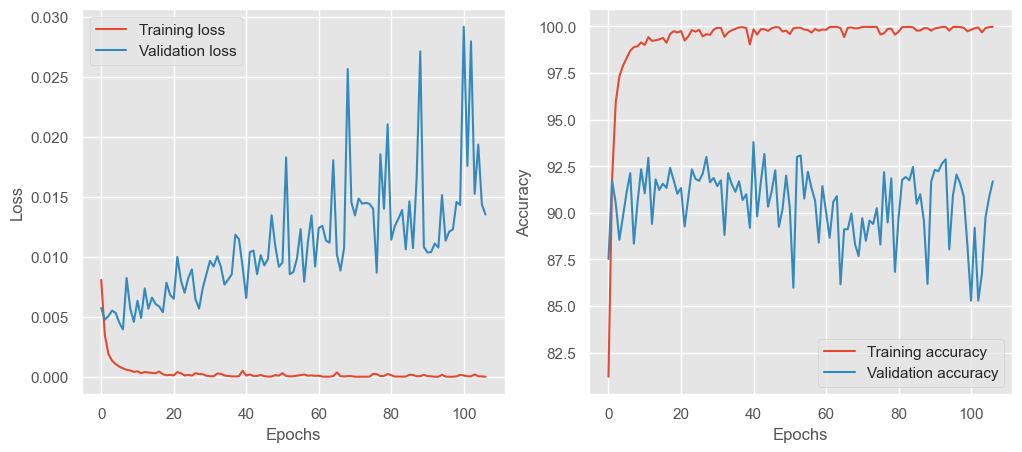

In [239]:
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy')
    plt.plot(val_accs, label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
print('Accuracy on val data: ', val_accs[-1])
print('Loss on val data: ', val_losses[-1])

plot_performance(train_losses, val_losses, train_accs, val_accs)

### remove dropout

In [241]:
# Create DataLoaders
batch_size = 64  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 1D Convolutional Neural Network
class CNN(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(CNN, self).__init__()
        self.n_sensors = n_sensors
        self.time_periods = time_periods
        self.n_classes = n_classes
        self.conv1 = nn.Conv1d(n_sensors, 100, kernel_size=10)
        self.conv2 = nn.Conv1d(100, 100, kernel_size=10)
        self.conv3 = nn.Conv1d(100, 160, kernel_size=10)
        self.conv4 = nn.Conv1d(160, 160, kernel_size=10)
        self.maxpool = nn.MaxPool1d(3)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(160, n_classes)

    def forward(self, x):
        x = x.view(-1, self.n_sensors, self.time_periods)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.adaptive_pool(x)
        x = x.view(-1, 160)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn = CNN(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn.to(device)

# Print model summary
print(model_cnn)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

BATCH_SIZE = 64
EPOCHS = 500

train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_loss = float('inf')
patience = 100
trigger_times = 0

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    global best_val_loss, trigger_times
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses.append(test_loss)
    val_accs.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            return True
    return False

for epoch in range(1, EPOCHS + 1):
    train(model_cnn, device, train_loader, my_optimizer, epoch)
    if validate(model_cnn, device, test_loader):
        break

CNN(
  (conv1): Conv1d(3, 100, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(10,), stride=(1,))
  (conv3): Conv1d(100, 160, kernel_size=(10,), stride=(1,))
  (conv4): Conv1d(160, 160, kernel_size=(10,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=160, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.007876 	Accuracy: 81.29%
Validation: Average loss: 0.0121, Accuracy: 2700/3888 (69.44%)
Train Epoch: 2 	Loss: 0.003266 	Accuracy: 92.07%
Validation: Average loss: 0.0051, Accuracy: 3403/3888 (87.53%)
Train Epoch: 3 	Loss: 0.002051 	Accuracy: 95.39%
Validation: Average loss: 0.0054, Accuracy: 3418/3888 (87.91%)
Train Epoch: 4 	Loss: 0.001367 	Accuracy: 97.11%
Validation: Average loss: 0.0061, Accuracy: 3400/3888 (87.45%)
Train Epoch: 5 	Loss: 0.001057 	Accuracy: 97.85%
Validation: Average loss: 0.0071, Accuracy: 3320/3888 (85.3

Accuracy on val data:  89.50617283950618
Loss on val data:  0.014532725707170768


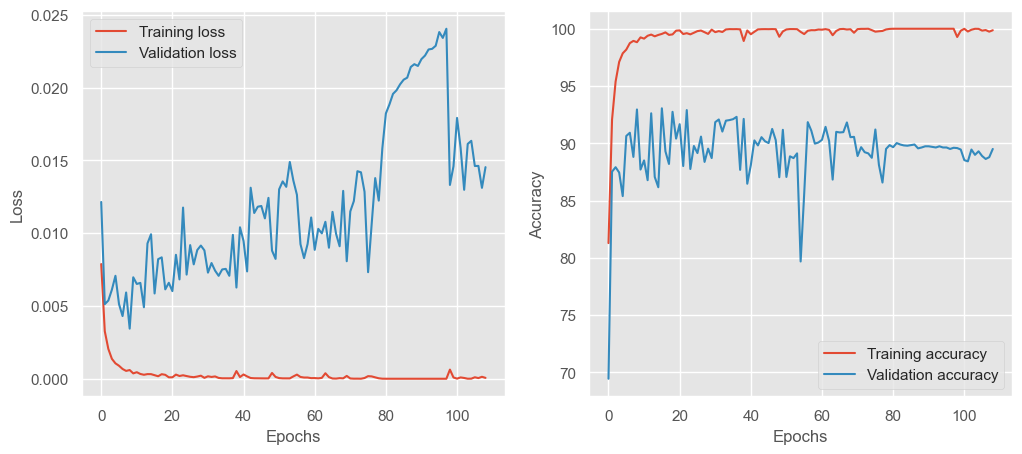

In [242]:
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy')
    plt.plot(val_accs, label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
print('Accuracy on val data: ', val_accs[-1])
print('Loss on val data: ', val_losses[-1])

plot_performance(train_losses, val_losses, train_accs, val_accs)

### 3.5.d Data Scaling 

### 10Hz

In [305]:
LABEL = 'ActivityEncoded'

le = preprocessing.LabelEncoder()  # string to Integer
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

df_train = df[df['user'] <= 28]
df_validate = df[df['user'].isin([31,30,29])]   # selects a portion of the data from df_train for validation purposes 
df_test = df[df['user'] > 32]

df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()

df_validate['x-axis'] = df_validate['x-axis'] / df_validate['x-axis'].max()
df_validate['y-axis'] = df_validate['y-axis'] / df_validate['y-axis'].max()
df_validate['z-axis'] = df_validate['z-axis'] / df_validate['z-axis'].max()

df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()

# round numbers
df_train = df_train.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})
df_validate = df_validate.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})
df_test = df_test.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})

def create_segments_and_labels(df, time_steps, step, label_name):
    # x, y, z acceleration as features
    N_FEATURES = 3

    # Number of steps to advance in each iteration
    # step = time_steps # no overlap between segments

    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]

        # find the most often used label in this segment
        label_mode_result = stats.mode(df[label_name][i: i + time_steps])
        if np.isscalar(label_mode_result.mode):
            label = label_mode_result.mode
        else:
            label = label_mode_result.mode[0]

        segments.append([xs, ys, zs])
        labels.append(label)

    # bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels  # x, y

# Define new time periods for downsampling
TIME_PERIODS = 80 // 2  # Adjust TIME_PERIODS for downsampling
STEP_DISTANCE = 40 // 2  # Adjust STEP_DISTANCE for downsampling

x_train, y_train = create_segments_and_labels(df_train.iloc[::2, :],
                                                        TIME_PERIODS,  # Adjust TIME_PERIODS accordingly
                                                        STEP_DISTANCE,  # Adjust STEP_DISTANCE accordingly
                                                        LABEL)

x_validate, y_validate = create_segments_and_labels(df_validate,
                                                    TIME_PERIODS,
                                                    STEP_DISTANCE,
                                                    LABEL)  # LABEL = 'ActivityEncoded'

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

# input, output dimensions
n_time_periods, n_sensors = x_train.shape[1], x_train.shape[2]
n_classes = le.classes_.size

input_shape = (n_time_periods * n_sensors)

x_train = x_train.reshape(x_train.shape[0], input_shape)
x_validate = x_validate.reshape(x_validate.shape[0], input_shape)
x_test =  x_test.reshape(x_test.shape[0], input_shape)

x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

x_validate = x_validate.astype('float32')
y_validate = y_validate.astype('float32')

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

def to_categorical(y, num_classes):
    return torch.eye(num_classes)[y]

n_classes = len(np.unique(y_train))  # Assuming y_train is available and contains your class labels
y_train_hot = to_categorical(y_train, n_classes)

# Convert your numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # long for CrossEntropyLoss
x_validate_tensor = torch.tensor(x_validate, dtype=torch.float32)
y_validate_tensor = torch.tensor(y_validate, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
validate_dataset = TensorDataset(x_validate_tensor, y_validate_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 64  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class CNN_Config1(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(CNN_Config1, self).__init__()
        self.n_sensors = n_sensors
        self.time_periods = time_periods
        self.n_classes = n_classes
        self.conv1 = nn.Conv1d(n_sensors, 64, kernel_size=5)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5)
        self.maxpool = nn.MaxPool1d(2)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, n_classes)

    def forward(self, x):
        x = x.view(-1, self.n_sensors, self.time_periods)
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.adaptive_pool(x)
        x = self.dropout(x)
        x = x.view(-1, 128)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn_config1 = CNN_Config1(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn_config1.to(device)

# Print model summary
print(model_cnn_config1)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_cnn_config1.parameters(), lr=0.001)

BATCH_SIZE = 64
EPOCHS = 500

train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_loss = float('inf')
patience = 20
trigger_times = 0

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    global best_val_loss, trigger_times
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses.append(test_loss)
    val_accs.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            return True
    return False

for epoch in range(1, EPOCHS + 1):
    train(model_cnn_config1, device, train_loader, my_optimizer, epoch)
    if validate(model_cnn_config1, device, test_loader):
        break
        
        
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy')
    plt.plot(val_accs, label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
print('Accuracy on val data: ', val_accs[-1])
print('Loss on val data: ', val_losses[-1])

plot_performance(train_losses, val_losses, train_accs, val_accs)

CNN_Config1(
  (conv1): Conv1d(3, 64, kernel_size=(5,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.012519 	Accuracy: 72.20%
Validation: Average loss: 0.0140, Accuracy: 4200/6001 (69.99%)
Train Epoch: 2 	Loss: 0.007720 	Accuracy: 82.01%
Validation: Average loss: 0.0168, Accuracy: 3106/6001 (51.76%)
Train Epoch: 3 	Loss: 0.006594 	Accuracy: 84.11%
Validation: Average loss: 0.0169, Accuracy: 3369/6001 (56.14%)
Train Epoch: 4 	Loss: 0.006133 	Accuracy: 85.18%
Validation: Average loss: 0.0161, Accuracy: 3266/6001 (54.42%)


KeyboardInterrupt: 

### 4HZ

CNN_Config1(
  (conv1): Conv1d(3, 64, kernel_size=(2,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(2,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.015155 	Accuracy: 66.39%
Validation: Average loss: 0.0170, Accuracy: 8546/15005 (56.95%)
Train Epoch: 2 	Loss: 0.010602 	Accuracy: 76.47%
Validation: Average loss: 0.0139, Accuracy: 10226/15005 (68.15%)
Train Epoch: 3 	Loss: 0.009507 	Accuracy: 78.14%
Validation: Average loss: 0.0150, Accuracy: 9128/15005 (60.83%)
Train Epoch: 4 	Loss: 0.008987 	Accuracy: 79.17%
Validation: Average loss: 0.0150, Accuracy: 9060/15005 (60.38%)
Train Epoch: 5 	Loss: 0.008567 	Accuracy: 80.02%
Validation: Average loss: 0.0160, Accuracy: 8434/15005 (56.21%)
Train Epoch: 6 	Loss: 0.008345 	Accuracy: 80.79%
Validation: Av

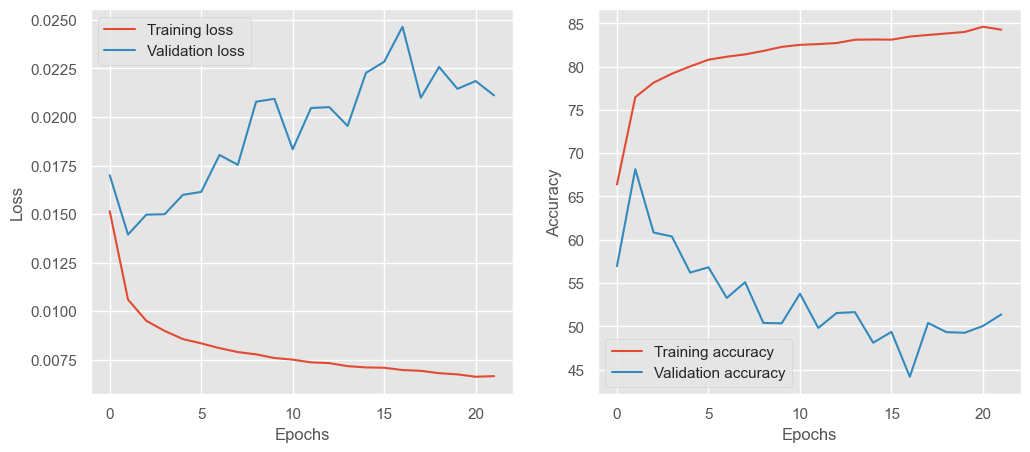

In [261]:
LABEL = 'ActivityEncoded'

le = preprocessing.LabelEncoder()  # string to Integer
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

df_train = df[df['user'] <= 28]
df_validate = df[df['user'].isin([31,30,29])]   # selects a portion of the data from df_train for validation purposes 
df_test = df[df['user'] > 32]

df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()

df_validate['x-axis'] = df_validate['x-axis'] / df_validate['x-axis'].max()
df_validate['y-axis'] = df_validate['y-axis'] / df_validate['y-axis'].max()
df_validate['z-axis'] = df_validate['z-axis'] / df_validate['z-axis'].max()

df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()

# round numbers
df_train = df_train.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})
df_validate = df_validate.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})
df_test = df_test.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})

def create_segments_and_labels(df, time_steps, step, label_name):
    # x, y, z acceleration as features
    N_FEATURES = 3

    # Number of steps to advance in each iteration
    # step = time_steps # no overlap between segments

    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]

        # find the most often used label in this segment
        label_mode_result = stats.mode(df[label_name][i: i + time_steps])
        if np.isscalar(label_mode_result.mode):
            label = label_mode_result.mode
        else:
            label = label_mode_result.mode[0]

        segments.append([xs, ys, zs])
        labels.append(label)

    # bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels  # x, y

# Define new time periods for downsampling
TIME_PERIODS = 80 // 5  # Adjust TIME_PERIODS for downsampling
STEP_DISTANCE = 40 // 5  # Adjust STEP_DISTANCE for downsampling

x_train, y_train = create_segments_and_labels(df_train.iloc[::5, :],
                                                        TIME_PERIODS,  # Adjust TIME_PERIODS accordingly
                                                        STEP_DISTANCE,  # Adjust STEP_DISTANCE accordingly
                                                        LABEL)

x_validate, y_validate = create_segments_and_labels(df_validate,
                                                    TIME_PERIODS,
                                                    STEP_DISTANCE,
                                                    LABEL)  # LABEL = 'ActivityEncoded'

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

# input, output dimensions
n_time_periods, n_sensors = x_train.shape[1], x_train.shape[2]
n_classes = le.classes_.size

input_shape = (n_time_periods * n_sensors)

x_train = x_train.reshape(x_train.shape[0], input_shape)
x_validate = x_validate.reshape(x_validate.shape[0], input_shape)
x_test =  x_test.reshape(x_test.shape[0], input_shape)

x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

x_validate = x_validate.astype('float32')
y_validate = y_validate.astype('float32')

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

def to_categorical(y, num_classes):
    return torch.eye(num_classes)[y]

n_classes = len(np.unique(y_train))  # Assuming y_train is available and contains your class labels
y_train_hot = to_categorical(y_train, n_classes)

# Convert your numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # long for CrossEntropyLoss
x_validate_tensor = torch.tensor(x_validate, dtype=torch.float32)
y_validate_tensor = torch.tensor(y_validate, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
validate_dataset = TensorDataset(x_validate_tensor, y_validate_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 64  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class CNN_Config1(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(CNN_Config1, self).__init__()
        self.n_sensors = n_sensors
        self.time_periods = time_periods
        self.n_classes = n_classes
        self.conv1 = nn.Conv1d(n_sensors, 64, kernel_size=2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=2)
        self.maxpool = nn.MaxPool1d(2)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, n_classes)

    def forward(self, x):
        x = x.view(-1, self.n_sensors, self.time_periods)
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.adaptive_pool(x)
        x = self.dropout(x)
        x = x.view(-1, 128)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn_config1 = CNN_Config1(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn_config1.to(device)

# Print model summary
print(model_cnn_config1)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_cnn_config1.parameters(), lr=0.001)

BATCH_SIZE = 64
EPOCHS = 500

train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_loss = float('inf')
patience = 20
trigger_times = 0

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    global best_val_loss, trigger_times
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses.append(test_loss)
    val_accs.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            return True
    return False

for epoch in range(1, EPOCHS + 1):
    train(model_cnn_config1, device, train_loader, my_optimizer, epoch)
    if validate(model_cnn_config1, device, test_loader):
        break
        
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy')
    plt.plot(val_accs, label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
print('Accuracy on val data: ', val_accs[-1])
print('Loss on val data: ', val_losses[-1])

plot_performance(train_losses, val_losses, train_accs, val_accs)

### 3.6.c Over Sampling

In [286]:
print("Before Over Sampling:", df['activity'].value_counts())


from sklearn.utils import resample

# Assuming 'df' is your DataFrame containing the 'activity' column
activity_counts = df['activity'].value_counts()
max_count = activity_counts.max()

# Create a new DataFrame for the balanced dataset
df_balanced = pd.DataFrame()

for activity, count in activity_counts.items():
    df_activity = df[df['activity'] == activity]
    # Resample the minority classes
    df_activity_resampled = resample(df_activity, replace=True, n_samples=max_count, random_state=42)
    df_balanced = pd.concat([df_balanced, df_activity_resampled])

# Check the new class distribution
print("After Over Sampling:", df_balanced['activity'].value_counts())

LABEL = 'ActivityEncoded'

le = preprocessing.LabelEncoder()  # string to Integer
df_balanced[LABEL] = le.fit_transform(df_balanced['activity'].values.ravel())

df_train = df_balanced[df_balanced['user'] <= 28]
df_validate = df_balanced[df_balanced['user'].isin([31,30,29])]   # selects a portion of the data from df_train for validation purposes 
df_test = df_balanced[df_balanced['user'] > 32]

df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()

df_validate['x-axis'] = df_validate['x-axis'] / df_validate['x-axis'].max()
df_validate['y-axis'] = df_validate['y-axis'] / df_validate['y-axis'].max()
df_validate['z-axis'] = df_validate['z-axis'] / df_validate['z-axis'].max()

df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()

# round numbers
df_train = df_train.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})
df_validate = df_validate.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})
df_test = df_test.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})

def create_segments_and_labels(df, time_steps, step, label_name):
    # x, y, z acceleration as features
    N_FEATURES = 3

    # Number of steps to advance in each iteration
    # step = time_steps # no overlap between segments

    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]

        # find the most often used label in this segment
        label_mode_result = stats.mode(df[label_name][i: i + time_steps])
        if np.isscalar(label_mode_result.mode):
            label = label_mode_result.mode
        else:
            label = label_mode_result.mode[0]

        segments.append([xs, ys, zs])
        labels.append(label)

    # bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels  # x, y

# Define new time periods for downsampling
TIME_PERIODS = 80   # Adjust TIME_PERIODS for downsampling
STEP_DISTANCE = 40  # Adjust STEP_DISTANCE for downsampling

x_train, y_train = create_segments_and_labels(df_train,
                                                        TIME_PERIODS,  # Adjust TIME_PERIODS accordingly
                                                        STEP_DISTANCE,  # Adjust STEP_DISTANCE accordingly
                                                        LABEL)

x_validate, y_validate = create_segments_and_labels(df_validate,
                                                    TIME_PERIODS,
                                                    STEP_DISTANCE,
                                                    LABEL)  # LABEL = 'ActivityEncoded'

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

# input, output dimensions
n_time_periods, n_sensors = x_train.shape[1], x_train.shape[2]
n_classes = le.classes_.size

input_shape = (n_time_periods * n_sensors)

x_train = x_train.reshape(x_train.shape[0], input_shape)
x_validate = x_validate.reshape(x_validate.shape[0], input_shape)
x_test =  x_test.reshape(x_test.shape[0], input_shape)

x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

x_validate = x_validate.astype('float32')
y_validate = y_validate.astype('float32')

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

def to_categorical(y, num_classes):
    return torch.eye(num_classes)[y]

n_classes = len(np.unique(y_train))  # Assuming y_train is available and contains your class labels
y_train_hot = to_categorical(y_train, n_classes)

# Convert your numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # long for CrossEntropyLoss
x_validate_tensor = torch.tensor(x_validate, dtype=torch.float32)
y_validate_tensor = torch.tensor(y_validate, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
validate_dataset = TensorDataset(x_validate_tensor, y_validate_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 64  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("x_train.shape", x_train.shape)
print("y_train.shape", y_train.shape)

Before Over Sampling: activity
Walking       424399
Jogging       342179
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: count, dtype: int64
After Over Sampling: activity
Walking       424399
Jogging       424399
Upstairs      424399
Downstairs    424399
Sitting       424399
Standing      424399
Name: count, dtype: int64
x_train.shape (47063, 240)
y_train.shape (47063,)


CNN_Config1(
  (conv1): Conv1d(3, 64, kernel_size=(2,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(2,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.008603 	Accuracy: 77.32%
Validation: Average loss: 0.0235, Accuracy: 3643/7408 (49.18%)
Train Epoch: 2 	Loss: 0.004550 	Accuracy: 87.76%
Validation: Average loss: 0.0321, Accuracy: 3532/7408 (47.68%)
Train Epoch: 3 	Loss: 0.003959 	Accuracy: 89.60%
Validation: Average loss: 0.0283, Accuracy: 3867/7408 (52.20%)
Train Epoch: 4 	Loss: 0.003614 	Accuracy: 90.46%
Validation: Average loss: 0.0330, Accuracy: 3652/7408 (49.30%)
Train Epoch: 5 	Loss: 0.003293 	Accuracy: 91.40%
Validation: Average loss: 0.0354, Accuracy: 3523/7408 (47.56%)
Train Epoch: 6 	Loss: 0.003072 	Accuracy: 91.94%
Validation: Average 

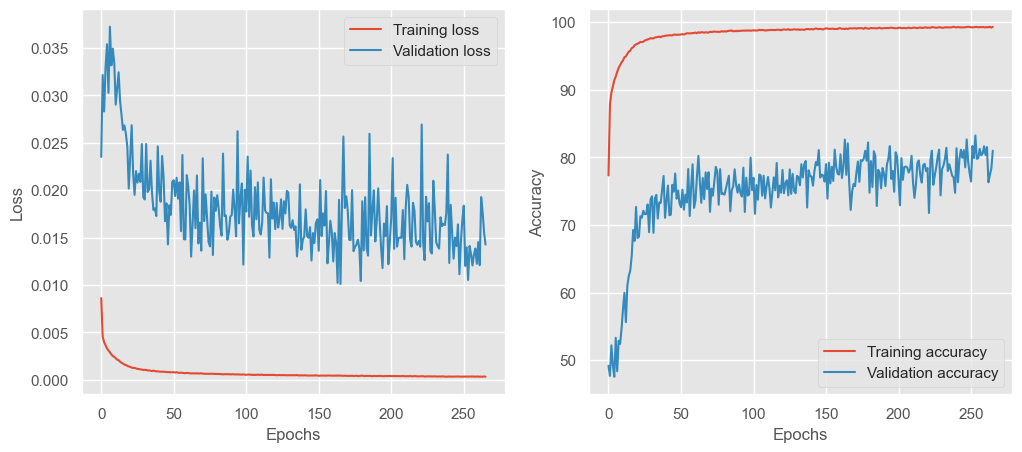

[[1226    0    0    2    0    0]
 [ 218  995    0    0   37    3]
 [   1    0 1574    0    0    0]
 [   0    0    0 1303    0    0]
 [ 692    0    0  100  206    0]
 [ 311    0    0    0   45  695]]


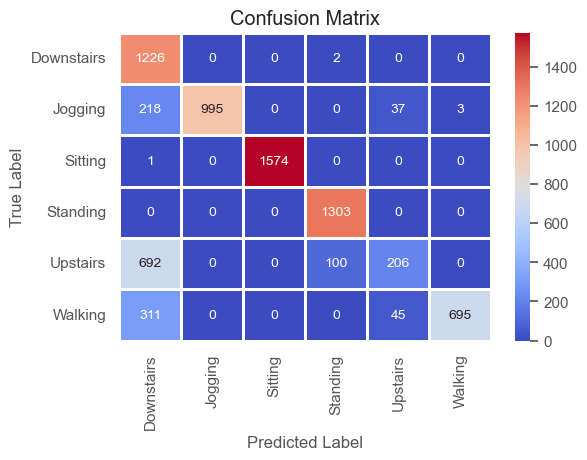

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1228
           1       1.00      0.79      0.89      1253
           2       1.00      1.00      1.00      1575
           3       0.93      1.00      0.96      1303
           4       0.72      0.21      0.32       998
           5       1.00      0.66      0.79      1051

    accuracy                           0.81      7408
   macro avg       0.86      0.78      0.77      7408
weighted avg       0.87      0.81      0.80      7408


In [287]:
class CNN_Config1(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(CNN_Config1, self).__init__()
        self.n_sensors = n_sensors
        self.time_periods = time_periods
        self.n_classes = n_classes
        self.conv1 = nn.Conv1d(n_sensors, 64, kernel_size=2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=2)
        self.maxpool = nn.MaxPool1d(2)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, n_classes)

    def forward(self, x):
        x = x.view(-1, self.n_sensors, self.time_periods)
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.adaptive_pool(x)
        x = self.dropout(x)
        x = x.view(-1, 128)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn_config1 = CNN_Config1(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn_config1.to(device)

# Print model summary
print(model_cnn_config1)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_cnn_config1.parameters(), lr=0.001)

BATCH_SIZE = 64
EPOCHS = 500

train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_loss = float('inf')
patience = 100
trigger_times = 0

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    global best_val_loss, trigger_times
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses.append(test_loss)
    val_accs.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            return True
    return False

for epoch in range(1, EPOCHS + 1):
    train(model_cnn_config1, device, train_loader, my_optimizer, epoch)
    if validate(model_cnn_config1, device, test_loader):
        break
        
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy')
    plt.plot(val_accs, label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
print('Accuracy on val data: ', val_accs[-1])
print('Loss on val data: ', val_losses[-1])

plot_performance(train_losses, val_losses, train_accs, val_accs)

def show_confusion_matrix(validaitons, predictions, title=None):
    matrix = metrics.confusion_matrix(validaitons, predictions)
    
    print(matrix)
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    if title: plt.title(title)
    else: plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Get the predictions and true labels
all_predictions = []
all_labels = []
for data, labels in test_loader:
    data = data.to(device)
    predictions = model_cnn_config1.predict(data)
    all_predictions.extend(predictions.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

show_confusion_matrix(all_labels, all_predictions)
print(classification_report(all_labels, all_predictions))

In [302]:
LABEL = 'ActivityEncoded'

le = preprocessing.LabelEncoder()  # string to Integer
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

df_train = df[df['user'] <= 28]
df_validate = df[df['user'].isin([31,30,29])]   # selects a portion of the data from df_train for validation purposes 
df_test = df[df['user'] > 32]

df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()

df_validate['x-axis'] = df_validate['x-axis'] / df_validate['x-axis'].max()
df_validate['y-axis'] = df_validate['y-axis'] / df_validate['y-axis'].max()
df_validate['z-axis'] = df_validate['z-axis'] / df_validate['z-axis'].max()

df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()

# round numbers
df_train = df_train.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})
df_validate = df_validate.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})
df_test = df_test.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})


import random

def randomly_eliminate_samples(df, target_counts):
    """
    Randomly eliminates samples from overrepresented classes to balance the dataset.
    
    Parameters:
        df (DataFrame): The original dataframe.
        target_counts (dict): A dictionary with class labels as keys and target counts as values.
    
    Returns:
        DataFrame: A balanced dataframe after random elimination.
    """
    balanced_df = pd.DataFrame()
    for label, target_count in target_counts.items():
        df_class = df[df[LABEL] == label]
        if len(df_class) > target_count:
            # Randomly select samples to keep
            df_class = df_class.sample(n=target_count, random_state=42)
        balanced_df = pd.concat([balanced_df, df_class])
    return balanced_df

# Calculate the target number of samples based on the least frequent class
min_count = df_train[LABEL].value_counts().min()
target_counts = {label: min_count for label in df_train[LABEL].unique()}

# Apply random elimination to balance the training dataset
df_train_balanced = randomly_eliminate_samples(df_train, target_counts)

def create_segments_and_labels(df, time_steps, step, label_name):
    # x, y, z acceleration as features
    N_FEATURES = 3

    # Number of steps to advance in each iteration
    # step = time_steps # no overlap between segments

    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]

        # find the most often used label in this segment
        label_mode_result = stats.mode(df[label_name][i: i + time_steps])
        if np.isscalar(label_mode_result.mode):
            label = label_mode_result.mode
        else:
            label = label_mode_result.mode[0]

        segments.append([xs, ys, zs])
        labels.append(label)

    # bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels  # x, y

# Define new time periods for downsampling
TIME_PERIODS = 80   # Adjust TIME_PERIODS for downsampling
STEP_DISTANCE = 40  # Adjust STEP_DISTANCE for downsampling

x_train, y_train = create_segments_and_labels(df_train_balanced,
                                              TIME_PERIODS,  # Adjust TIME_PERIODS accordingly
                                              STEP_DISTANCE,  # Adjust STEP_DISTANCE accordingly
                                              LABEL)

x_validate, y_validate = create_segments_and_labels(df_validate,
                                                    TIME_PERIODS,
                                                    STEP_DISTANCE,
                                                    LABEL)  # LABEL = 'ActivityEncoded'

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

# input, output dimensions
n_time_periods, n_sensors = x_train.shape[1], x_train.shape[2]
n_classes = le.classes_.size

input_shape = (n_time_periods * n_sensors)

x_train = x_train.reshape(x_train.shape[0], input_shape)
x_validate = x_validate.reshape(x_validate.shape[0], input_shape)
x_test =  x_test.reshape(x_test.shape[0], input_shape)

x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

x_validate = x_validate.astype('float32')
y_validate = y_validate.astype('float32')

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

def to_categorical(y, num_classes):
    return torch.eye(num_classes)[y]

n_classes = len(np.unique(y_train))  # Assuming y_train is available and contains your class labels
y_train_hot = to_categorical(y_train, n_classes)

# Convert your numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # long for CrossEntropyLoss
x_validate_tensor = torch.tensor(x_validate, dtype=torch.float32)
y_validate_tensor = torch.tensor(y_validate, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
validate_dataset = TensorDataset(x_validate_tensor, y_validate_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 64  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("x_train.shape", x_train.shape)
print("y_train.shape", y_train.shape)

x_train.shape (5017, 240)
y_train.shape (5017,)
